In [1]:
import re
from typing import List, Dict, Tuple
from collections import Counter

class TokenizationAnalyzer:
    """
    Analyze and demonstrate tokenization issues and solutions for graph representations.
    """

    def __init__(self):
        # Simulate different tokenization behaviors
        self.tokenizers = {
            'gpt': self.gpt_style_tokenize,
            'bert': self.bert_style_tokenize,
            'whitespace': self.whitespace_tokenize
        }

    def gpt_style_tokenize(self, text: str) -> List[str]:
        """Simulate GPT-style BPE tokenization."""
        # GPT tends to merge common prefixes and split on case/numbers
        tokens = []
        # Split on special characters and spaces
        parts = re.findall(r'[A-Z]+|[a-z]+|[0-9]+|[^A-Za-z0-9]+', text)
        for part in parts:
            if len(part) > 4:
                # Long words might be split
                tokens.extend([part[i:i+3] for i in range(0, len(part), 3)])
            else:
                tokens.append(part)
        return [t for t in tokens if t.strip()]

    def bert_style_tokenize(self, text: str) -> List[str]:
        """Simulate BERT-style WordPiece tokenization."""
        # BERT uses ## for subwords
        tokens = []
        words = text.split()
        for word in words:
            if len(word) > 5:
                tokens.append(word[:3])
                tokens.append('##' + word[3:])
            else:
                tokens.append(word)
        return tokens

    def whitespace_tokenize(self, text: str) -> List[str]:
        """Simple whitespace tokenization."""
        return text.split()

    def analyze_representation(self, representation: str, tokenizer_type: str = 'gpt') -> Dict:
        """Analyze tokenization consistency for a representation."""
        tokenizer = self.tokenizers[tokenizer_type]
        tokens = tokenizer(representation)

        # Find node references
        node_pattern = r'(n\d{4}|N_[A-Z]{4}|[a-z]+pus\d*|[A-Z]{1,4})'
        nodes = re.findall(node_pattern, representation)

        # Check how each node is tokenized
        node_tokenizations = {}
        for node in set(nodes):
            node_tokens = tokenizer(node)
            node_tokenizations[node] = node_tokens

        return {
            'total_tokens': len(tokens),
            'unique_nodes': len(set(nodes)),
            'node_tokenizations': node_tokenizations,
            'avg_tokens_per_node': sum(len(t) for t in node_tokenizations.values()) / len(node_tokenizations) if node_tokenizations else 0
        }

    def compare_formats(self, formats: Dict[str, str]) -> Dict:
        """Compare tokenization efficiency across formats."""
        results = {}

        for format_name, representation in formats.items():
            analysis = self.analyze_representation(representation)
            results[format_name] = {
                'total_tokens': analysis['total_tokens'],
                'tokens_per_node': analysis['avg_tokens_per_node'],
                'consistency': self._check_consistency(analysis['node_tokenizations'])
            }

        return results

    def _check_consistency(self, node_tokenizations: Dict) -> str:
        """Check if similar nodes are tokenized consistently."""
        if not node_tokenizations:
            return "N/A"

        # Group by tokenization pattern
        pattern_groups = {}
        for node, tokens in node_tokenizations.items():
            pattern = len(tokens)
            if pattern not in pattern_groups:
                pattern_groups[pattern] = []
            pattern_groups[pattern].append(node)

        if len(pattern_groups) == 1:
            return "Highly consistent"
        elif len(pattern_groups) == 2:
            return "Mostly consistent"
        else:
            return "Inconsistent"


class OptimizedGraphTokenization:
    """
    Optimized representations for consistent tokenization across different tokenizers.
    """

    @staticmethod
    def numeric_id_format(nodes: List[int], edges: List[Tuple[int, int]]) -> str:
        """
        Use numeric IDs with consistent padding.
        Format: n0001, n0002, etc.

        Advantages:
        - Each node is likely a single token
        - Consistent length prevents splitting
        - Numeric ordering preserved
        """
        edge_str = ' '.join([f"n{u:04d},n{v:04d}" for u, v in edges])
        return f"E: {edge_str}"

    @staticmethod
    def special_token_format(nodes: List[int], edges: List[Tuple[int, int]]) -> str:
        """
        Use special tokens that won't be split by tokenizers.
        Format: <node_001>, <node_002>, etc.

        Advantages:
        - Special tokens are usually preserved
        - Clear boundaries
        - Can be added to tokenizer vocabulary
        """
        edge_str = ' '.join([f"<n{u:03d}>-><n{v:03d}>" for u, v in edges])
        return f"GRAPH {edge_str}"

    @staticmethod
    def byte_pair_friendly_format(nodes: List[int], edges: List[Tuple[int, int]]) -> str:
        """
        Format optimized for BPE tokenization.
        Uses common prefixes and consistent structure.

        Format: X0001, X0002 (where X is a common prefix)
        """
        edge_str = ' '.join([f"X{u:04d} X{v:04d}" for u, v in edges])
        return edge_str

    @staticmethod
    def hash_based_format(nodes: List[int], edges: List[Tuple[int, int]]) -> str:
        """
        Use hash-based short IDs for massive graphs.
        Converts node IDs to base-36 for compactness.

        Supports up to 36^4 = 1,679,616 nodes with 4 characters
        """
        def to_base36(num):
            chars = "0123456789abcdefghijklmnopqrstuvwxyz"
            result = []
            while num:
                result.append(chars[num % 36])
                num //= 36
            return ''.join(reversed(result)).zfill(4)

        edge_str = ' '.join([f"h{to_base36(u)}_h{to_base36(v)}" for u, v in edges])
        return edge_str


def demonstrate_tokenization_issues():
    """Demonstrate why tokenization matters for graph learning."""

    print("=" * 60)
    print("TOKENIZATION ANALYSIS FOR GRAPH REPRESENTATIONS")
    print("=" * 60)

    # Sample edges
    edges = [(0, 5), (5, 23), (23, 147), (147, 892), (892, 3654)]

    # Different representation formats
    formats = {
        'concept_names': "lorpus0->rorpus5, rorpus5->bompus23, bompus23->terpus147",
        'variable_length': "A->B, B->CD, CD->EFG, EFG->HIJK",  # Inconsistent!
        'numeric_consistent': "n0000,n0005 n0005,n0023 n0023,n0147",
        'special_tokens': "<n000>-><n005> <n005>-><n023> <n023>-><n147>",
        'base36_compact': "h0000_h0005 h0005_h000n h000n_h0043"
    }

    analyzer = TokenizationAnalyzer()

    print("\nTokenization Analysis Results:")
    print("-" * 40)

    for format_name, representation in formats.items():
        print(f"\n{format_name.upper()}:")
        print(f"Text: {representation[:50]}...")

        for tokenizer_name in ['gpt', 'bert', 'whitespace']:
            analysis = analyzer.analyze_representation(representation, tokenizer_name)
            print(f"  {tokenizer_name}: {analysis['total_tokens']} tokens, "
                  f"{analysis['avg_tokens_per_node']:.1f} tokens/node")

    print("\n" + "=" * 60)
    print("KEY INSIGHTS:")
    print("-" * 40)
    print("""
    1. INCONSISTENT TOKENIZATION HURTS LEARNING:
       - Variable-length node names (A, CD, EFG) tokenize differently
       - Model wastes capacity learning these variations
       - Makes it harder to generalize patterns

    2. OPTIMAL FORMAT CHARACTERISTICS:
       - Fixed-length identifiers (n0001, h0a3f)
       - Common prefixes for grouping (all nodes start with 'n' or 'h')
       - Avoid mixed alphanumeric that might split oddly

    3. FOR LARGE GRAPHS (>10K nodes):
       - Use base-36 encoding: 4 chars = 1.6M nodes
       - Or numeric with padding: n00000 to n99999
       - Consider training custom tokenizer for your format

    4. RECOMMENDATION FOR YOUR CASE:
       - Use 'n{:05d}' format for up to 100K nodes
       - Or 'h{base36}' for up to 1.6M nodes
       - Add these as special tokens if training custom tokenizer
    """)


class CustomTokenizerConfig:
    """Configuration for training a custom tokenizer for graph data."""

    @staticmethod
    def get_special_tokens(max_nodes: int) -> List[str]:
        """Generate special tokens for nodes."""
        if max_nodes <= 10000:
            return [f"<n{i:04d}>" for i in range(max_nodes)]
        elif max_nodes <= 100000:
            return [f"<n{i:05d}>" for i in range(max_nodes)]
        else:
            # Use base-36 for very large graphs
            def to_base36(num):
                chars = "0123456789abcdefghijklmnopqrstuvwxyz"
                result = []
                while num:
                    result.append(chars[num % 36])
                    num //= 36
                return ''.join(reversed(result)).zfill(4)

            return [f"<h{to_base36(i)}>" for i in range(min(max_nodes, 1679616))]

    @staticmethod
    def get_tokenizer_config(vocab_size: int = 32000) -> Dict:
        """Get configuration for training custom tokenizer."""
        return {
            'vocab_size': vocab_size,
            'min_frequency': 2,
            'special_tokens': [
                '<pad>', '<unk>', '<s>', '</s>',
                '[GRAPH]', '[QUERY]', '[PATH]', '[ANSWER]',
                '[REL]', '[NODE]', '[EDGE]', '[FIND]'
            ],
            'pre_tokenization': {
                'split_on': r'[\s,;|]',  # Split on whitespace and delimiters
                'preserve': r'<[^>]+>|n\d{4,5}|h[0-9a-z]{4}'  # Keep these intact
            }
        }


if __name__ == "__main__":
    # Run demonstration
    demonstrate_tokenization_issues()

    # Show optimal format for large graphs
    print("\n" + "=" * 60)
    print("OPTIMAL FORMAT FOR YOUR USE CASE:")
    print("=" * 60)

    opt = OptimizedGraphTokenization()
    sample_edges = [(0, 100), (100, 5000), (5000, 50000)]

    print("\nNumeric ID format (up to 100K nodes):")
    print(opt.numeric_id_format([], sample_edges))

    print("\nHash-based format (up to 1.6M nodes):")
    print(opt.hash_based_format([], sample_edges))

    print("\nSpecial token format (requires custom tokenizer):")
    print(opt.special_token_format([], sample_edges))

TOKENIZATION ANALYSIS FOR GRAPH REPRESENTATIONS

Tokenization Analysis Results:
----------------------------------------

CONCEPT_NAMES:
Text: lorpus0->rorpus5, rorpus5->bompus23, bompus23->ter...
  gpt: 23 tokens, 3.0 tokens/node
  bert: 6 tokens, 2.0 tokens/node
  whitespace: 3 tokens, 1.0 tokens/node

VARIABLE_LENGTH:
Text: A->B, B->CD, CD->EFG, EFG->HIJK...
  gpt: 15 tokens, 1.0 tokens/node
  bert: 7 tokens, 1.0 tokens/node
  whitespace: 4 tokens, 1.0 tokens/node

NUMERIC_CONSISTENT:
Text: n0000,n0005 n0005,n0023 n0023,n0147...
  gpt: 15 tokens, 2.0 tokens/node
  bert: 6 tokens, 1.0 tokens/node
  whitespace: 3 tokens, 1.0 tokens/node

SPECIAL_TOKENS:
Text: <n000>-><n005> <n005>-><n023> <n023>-><n147>...
  gpt: 19 tokens, 0.0 tokens/node
  bert: 6 tokens, 0.0 tokens/node
  whitespace: 3 tokens, 0.0 tokens/node

BASE36_COMPACT:
Text: h0000_h0005 h0005_h000n h000n_h0043...
  gpt: 17 tokens, 0.0 tokens/node
  bert: 6 tokens, 0.0 tokens/node
  whitespace: 3 tokens, 0.0 tokens/node

KEY 

In [ ]:
import random
import json
from typing import List, Dict, Tuple, Optional
import networkx as nx

class StructuredGraphRepresentations:
    """Different ways to represent graph structure for training from scratch."""

    def __init__(self, graph, concepts):
        self.graph = graph
        self.concepts = concepts

    def edge_list_representation(self, path: List[int], context_edges: List[Tuple[int, int]]) -> Dict:
        """
        Represent graph as explicit edge list with special tokens.
        Most efficient for learning graph structure.
        """
        # Format: [GRAPH] node1->node2, node3->node4, ... [QUERY] start->?->target [REASON]

        edge_strings = []
        for u, v in context_edges:
            edge_strings.append(f"{self.concepts[u]}->{self.concepts[v]}")

        start = self.concepts[path[0]]
        target = self.concepts[path[-1]]

        # Build reasoning chain
        reasoning = []
        for i in range(len(path) - 1):
            reasoning.append(f"{self.concepts[path[i]]}->{self.concepts[path[i+1]]}")

        return {
            'input': f"[GRAPH] {', '.join(edge_strings)} [QUERY] {start}->?->{target}",
            'output': f"[PATH] {' -> '.join(reasoning)} [ANSWER] Yes",
            'format': 'edge_list'
        }

    def adjacency_representation(self, path: List[int], context_edges: List[Tuple[int, int]]) -> Dict:
        """
        Represent as adjacency lists - more compact for dense graphs.
        """
        # Build adjacency structure from context edges
        adjacency = {}
        for u, v in context_edges:
            u_name = self.concepts[u]
            v_name = self.concepts[v]
            if u_name not in adjacency:
                adjacency[u_name] = []
            adjacency[u_name].append(v_name)

        # Format as structured text
        adj_strings = []
        for node, neighbors in sorted(adjacency.items()):
            adj_strings.append(f"{node}:[{','.join(neighbors)}]")

        start = self.concepts[path[0]]
        target = self.concepts[path[-1]]

        reasoning = [self.concepts[n] for n in path]

        return {
            'input': f"[ADJ] {'; '.join(adj_strings)} [QUERY] path({start},{target})?",
            'output': f"[PATH] {'>'.join(reasoning)}",
            'format': 'adjacency'
        }

    def triple_representation(self, path: List[int], context_edges: List[Tuple[int, int]]) -> Dict:
        """
        Knowledge graph triple format: (subject, predicate, object)
        Good for incorporating different edge types later.
        """
        triples = []
        for u, v in context_edges:
            # Using 'IS_A' as default relation, but could vary this
            triples.append(f"({self.concepts[u]}, IS_A, {self.concepts[v]})")

        start = self.concepts[path[0]]
        target = self.concepts[path[-1]]

        reasoning_triples = []
        for i in range(len(path) - 1):
            reasoning_triples.append(
                f"({self.concepts[path[i]]}, IS_A, {self.concepts[path[i+1]]})"
            )

        return {
            'input': f"[KB] {' '.join(triples)} [ASK] ({start}, IS_A+, {target})?",
            'output': f"[PROOF] {' '.join(reasoning_triples)} [TRUE]",
            'format': 'triple'
        }

    def matrix_representation(self, path: List[int], context_edges: List[Tuple[int, int]]) -> Dict:
        """
        Sparse matrix representation with node indexing.
        Most compact for very large graphs.
        """
        # Get unique nodes from context
        nodes_in_context = set()
        for u, v in context_edges:
            nodes_in_context.add(u)
            nodes_in_context.add(v)

        # Create node index mapping
        node_list = sorted(list(nodes_in_context))
        node_to_idx = {n: i for i, n in enumerate(node_list)}

        # Build edge list with indices
        indexed_edges = []
        for u, v in context_edges:
            if u in node_to_idx and v in node_to_idx:
                indexed_edges.append(f"{node_to_idx[u]},{node_to_idx[v]}")

        # Create node legend
        legend = [f"{i}:{self.concepts[n]}" for i, n in enumerate(node_list)]

        # Find indices for query
        start_idx = node_to_idx.get(path[0], -1)
        target_idx = node_to_idx.get(path[-1], -1)

        # Build path with indices
        path_indices = []
        for node in path:
            if node in node_to_idx:
                path_indices.append(str(node_to_idx[node]))

        return {
            'input': f"[NODES] {' '.join(legend)} [EDGES] {' '.join(indexed_edges)} [FIND] {start_idx}->?->{target_idx}",
            'output': f"[CHAIN] {'>'.join(path_indices)}",
            'format': 'matrix'
        }

    def hybrid_representation(self, path: List[int], context_edges: List[Tuple[int, int]],
                            include_language: bool = True) -> Dict:
        """
        Combine structured and natural language for best of both worlds.
        Good balance for models that need to understand both formats.
        """
        # Structured part
        edge_list = [f"{self.concepts[u]}->{self.concepts[v]}" for u, v in context_edges]

        # Natural language part (optional)
        nl_statements = []
        if include_language:
            for u, v in random.sample(context_edges, min(5, len(context_edges))):
                nl_statements.append(f"Every {self.concepts[u]} is a {self.concepts[v]}.")

        start = self.concepts[path[0]]
        target = self.concepts[path[-1]]

        # Reasoning combines both formats
        reasoning_structured = [f"{self.concepts[path[i]]}->{self.concepts[path[i+1]]}"
                               for i in range(len(path) - 1)]

        reasoning_natural = [f"{self.concepts[path[i]]} is a {self.concepts[path[i+1]]}"
                           for i in range(len(path) - 1)]

        input_text = f"[EDGES] {' '.join(edge_list)}"
        if nl_statements:
            input_text += f" [FACTS] {' '.join(nl_statements)}"
        input_text += f" [QUERY] Is {start} a {target}?"

        output_text = f"[CHAIN] {' '.join(reasoning_structured)} [EXPLAIN] {'. '.join(reasoning_natural)}. Therefore, yes."

        return {
            'input': input_text,
            'output': output_text,
            'format': 'hybrid'
        }

    def symbolic_representation(self, path: List[int], context_edges: List[Tuple[int, int]]) -> Dict:
        """
        Pure symbolic representation with 4-letter codes (supports up to 26^4 = 456,976 nodes).
        Uses tokenization-friendly format with underscores.
        """
        # Map concepts to 4-letter symbols (AAAA to ZZZZ)
        node_to_symbol = {}
        symbol_counter = 0

        def get_symbol(node, symbol_counter):
            if node not in node_to_symbol:
                # Generate 4-letter code with underscores for consistent tokenization
                # Format: N_XXXX where N is a prefix and XXXX is a 4-letter code
                base_26 = []
                temp = symbol_counter
                for _ in range(4):
                    base_26.append(chr(65 + (temp % 26)))
                    temp //= 26
                # Use underscore prefix to ensure consistent tokenization
                node_to_symbol[node] = f"N_{''.join(reversed(base_26))}"
                symbol_counter = len(node_to_symbol)
            return node_to_symbol[node], symbol_counter

        # Convert edges to symbolic form with consistent delimiters
        symbolic_edges = []
        for u, v in context_edges:
            u_sym, symbol_counter = get_symbol(u, symbol_counter)
            v_sym, symbol_counter = get_symbol(v, symbol_counter)
            # Use comma separator instead of -> for better tokenization
            symbolic_edges.append(f"{u_sym},{v_sym}")

        # Query in symbolic form
        start_symbol, symbol_counter = get_symbol(path[0], symbol_counter)
        target_symbol, symbol_counter = get_symbol(path[-1], symbol_counter)

        # Path in symbolic form with consistent separators
        path_symbols = []
        for n in path:
            symbol, symbol_counter = get_symbol(n, symbol_counter)
            path_symbols.append(symbol)

        # Include symbol mapping for interpretability
        mapping = [f"{sym}={self.concepts[node]}"
                  for node, sym in sorted(node_to_symbol.items(), key=lambda x: x[1])]

        return {
            'input': f"[DEF] {' '.join(mapping)} [REL] {' '.join(symbolic_edges)} [Q] {start_symbol},{target_symbol}",
            'output': f"[PATH] {','.join(path_symbols)}",
            'format': 'symbolic'
        }

    def tokenization_safe_representation(self, path: List[int], context_edges: List[Tuple[int, int]]) -> Dict:
        """
        Representation optimized for consistent tokenization.
        Uses numeric IDs with special prefixes to ensure each node is a single token.
        """
        # Use numeric representation with consistent prefix
        # Format: n0001, n0002, etc. - will be consistently tokenized

        def get_node_id(node_idx):
            return f"n{node_idx:04d}"  # Padded to 4 digits

        # Convert edges to ID format
        edge_strings = []
        for u, v in context_edges:
            edge_strings.append(f"{get_node_id(u)} {get_node_id(v)}")

        # Build path
        path_ids = [get_node_id(n) for n in path]

        # Create concept mapping
        concept_map = [f"{get_node_id(i)}:{self.concepts[i]}"
                      for i in sorted(set([u for u, v in context_edges] +
                                         [v for u, v in context_edges] +
                                         path))]

        return {
            'input': f"NODES {' '.join(concept_map)} EDGES {' '.join(edge_strings)} FIND {path_ids[0]} {path_ids[-1]}",
            'output': f"CHAIN {' '.join(path_ids)}",
            'format': 'tokenization_safe'
        }


class ImprovedDatasetGenerator:
    """Enhanced generator with multiple representation formats."""

    def __init__(self, num_nodes=100, num_edges=200, seed=42):
        random.seed(seed)
        self.num_nodes = num_nodes
        self.num_edges = num_edges

        # Generate concepts and graph
        self.concepts = self._generate_concepts(num_nodes)
        self.graph = self._build_dag()
        self.repr_gen = StructuredGraphRepresentations(self.graph, self.concepts)

        # Precompute paths
        self.all_edges = list(self.graph.edges())
        self.all_paths = dict(nx.all_pairs_shortest_path(self.graph))

    def _generate_concepts(self, n):
        """Generate concept names."""
        prefixes = ['lor', 'ror', 'bom', 'ter', 'ger', 'yim', 'fem', 'scrom']
        suffixes = ['pus', 'mus', 'tus', 'kus', 'nus']

        concepts = []
        for i in range(n):
            prefix = prefixes[i % len(prefixes)]
            suffix = suffixes[(i // len(prefixes)) % len(suffixes)]
            concepts.append(f"{prefix}{suffix}{i}")

        return concepts

    def _build_dag(self):
        """Build a DAG."""
        G = nx.DiGraph()
        for i in range(self.num_nodes):
            G.add_node(i)

        edges_added = 0
        attempts = 0
        max_attempts = self.num_edges * 10

        while edges_added < self.num_edges and attempts < max_attempts:
            attempts += 1
            u, v = random.sample(range(self.num_nodes), 2)
            if u > v:
                u, v = v, u

            if not G.has_edge(u, v):
                G.add_edge(u, v)
                if nx.is_directed_acyclic_graph(G):
                    edges_added += 1
                else:
                    G.remove_edge(u, v)

        return G

    def generate_multi_format_sample(self, representation_type='edge_list',
                                    depth_range=(3, 6), num_context_edges=20):
        """
        Generate a sample in specified representation format.

        Args:
            representation_type: One of 'edge_list', 'adjacency', 'triple',
                               'matrix', 'hybrid', 'symbolic', or 'mixed'
            depth_range: Min and max path length
            num_context_edges: Number of context edges to include
        """
        # Find a valid path
        min_depth, max_depth = depth_range
        path = self._find_path(min_depth, max_depth)
        if not path:
            return None

        # Sample context edges
        context_edges = self._sample_context_edges(path, num_context_edges)

        # Generate representation based on type
        if representation_type == 'mixed':
            # Randomly choose a representation for each sample
            representation_type = random.choice(['edge_list', 'adjacency', 'triple',
                                                'matrix', 'hybrid', 'symbolic'])

        # Get the appropriate representation
        if representation_type == 'edge_list':
            return self.repr_gen.edge_list_representation(path, context_edges)
        elif representation_type == 'adjacency':
            return self.repr_gen.adjacency_representation(path, context_edges)
        elif representation_type == 'triple':
            return self.repr_gen.triple_representation(path, context_edges)
        elif representation_type == 'matrix':
            return self.repr_gen.matrix_representation(path, context_edges)
        elif representation_type == 'hybrid':
            return self.repr_gen.hybrid_representation(path, context_edges)
        elif representation_type == 'symbolic':
            return self.repr_gen.symbolic_representation(path, context_edges)
        else:
            # Default to edge list
            return self.repr_gen.edge_list_representation(path, context_edges)

    def _find_path(self, min_length, max_length):
        """Find a path of appropriate length."""
        for _ in range(100):
            start = random.choice(list(self.graph.nodes()))
            if start in self.all_paths:
                valid_targets = []
                for target, path in self.all_paths[start].items():
                    if min_length <= len(path) - 1 <= max_length:
                        valid_targets.append((target, path))

                if valid_targets:
                    _, path = random.choice(valid_targets)
                    return path
        return None

    def _sample_context_edges(self, path, num_edges):
        """Sample context edges with bias toward path edges."""
        path_nodes = set(path)
        self.all_edges = list(self.graph.edges())

        weights = []
        for u, v in self.all_edges:
            if u in path_nodes or v in path_nodes:
                weights.append(3.0)  # Higher weight for edges near path
            else:
                weights.append(1.0)

        sampled_indices = random.choices(
            range(len(self.all_edges)),
            weights=weights,
            k=min(num_edges, len(self.all_edges))
        )

        return [self.all_edges[i] for i in set(sampled_indices)]


# Example usage
if __name__ == "__main__":
    generator = ImprovedDatasetGenerator(num_nodes=50, num_edges=100)

    print("=" * 60)
    print("COMPARING DIFFERENT REPRESENTATIONS")
    print("=" * 60)

    # Generate the same logical problem in different formats
    formats = ['edge_list', 'adjacency', 'triple', 'matrix', 'hybrid', 'symbolic']

    for fmt in formats:
        sample = generator.generate_multi_format_sample(
            representation_type=fmt,
            depth_range=(3, 5),
            num_context_edges=10
        )

        if sample:
            print(f"\n{fmt.upper()} FORMAT:")
            print("-" * 40)
            print(f"Input: {sample['input'][:1000]}...")
            print(f"Output: {sample['output']}")
            print()

COMPARING DIFFERENT REPRESENTATIONS

EDGE_LIST FORMAT:
----------------------------------------
Input: [GRAPH] rorpus41->yimpus45, rorpus1->scrompus7, bompus2->femmus14, rorkus25->scromkus31, terkus27->yimnus37, terpus3->scrommus15, scrommus15->rortus17, rortus17->yimkus29, scrompus7->fempus46 [QUERY] scrommus15->?->rormus49...
Output: [PATH] scrommus15->rortus17 -> rortus17->yimkus29 -> yimkus29->rorpus41 -> rorpus41->rormus49 [ANSWER] Yes


ADJACENCY FORMAT:
----------------------------------------
Input: [ADJ] bommus10:[scromtus23]; lorpus0:[fempus46]; rorpus1:[femnus38]; rortus17:[yimtus21]; scrompus7:[lorpus40]; scromtus23:[lorpus40]; termus11:[lornus32]; yimmus13:[gernus36]; yimnus37:[scrompus47]; yimtus21:[lormus48] [QUERY] path(yimmus13,lorpus40)?...
Output: [PATH] yimmus13>femtus22>femnus38>lorpus40


TRIPLE FORMAT:
----------------------------------------
Input: [KB] (tertus19, IS_A, scromtus23) (rorpus1, IS_A, femnus38) (femtus22, IS_A, femnus38) (terpus3, IS_A, scrommus15) 

In [1]:
import random
import networkx as nx
from collections import defaultdict
from typing import List, Tuple, Dict, Optional, Set
import json

class SubProsQADataset:
    """
    Generate ProsQA-style dataset with binary questions with a single huge graph shared between all samples.
    Question format: "Is X a Y or a Z?" in the symbolic format, one node is reachable, another is not.
    Context format: [EDGES] X->Y, Y->Z, Z->X;
    where edges are randomly sampled from the graph with higher probability for edges around the path.
    """

    def __init__(
        self,
        num_nodes=1000,
        num_edges=2000,
        num_samples=10000,
        num_context_edges=20,
        representation='structured',
        context_edge_proximity_weight=5.0,
        num_nodes_precompute=None, # for all nodes by default
        candidate_samples_path=None, # for precomputed samples, either save or load
        load_candidate_samples=False,
        dataset_path=None, # for precomputed dataset, either save or load
        load_dataset=False,
        depth_range=(3, 6),
        seed=42
    ):
        random.seed(seed)
        self.num_nodes = num_nodes
        self.num_edges = num_edges
        self.num_samples = num_samples
        self.num_context_edges = num_context_edges
        self.representation = representation
        self.context_edge_proximity_weight = context_edge_proximity_weight
        self.num_nodes_precompute = num_nodes_precompute
        self.candidate_samples_path = candidate_samples_path
        self.load_candidate_samples = load_candidate_samples
        self.dataset_path = dataset_path
        self.load_dataset = load_dataset
        self.depth_range = depth_range

        self.concepts = [f"concept{i:04d}" for i in range(num_nodes)]
        self.graph = self._build_dag()
        self.all_edges = list(self.graph.edges())

        if self.load_dataset and self.dataset_path:
            print(f"Loading dataset from {self.dataset_path}...")
            self.dataset = self._load_dataset(self.dataset_path)
            self.candidate_samples = None
        else:
            # Generate new dataset
            if self.load_candidate_samples and self.candidate_samples_path:
                self.candidate_samples = self._load_candidate_samples(self.candidate_samples_path)
            else:
                self.candidate_samples = self._precompute_candidate_samples()
                if self.candidate_samples_path:
                    self._save_candidate_samples(self.candidate_samples, self.candidate_samples_path)

            self.dataset = self.create_dataset()
            self._save_dataset(self.dataset, self.dataset_path)

        print(f"Graph created: {num_nodes} nodes, {self.graph.number_of_edges()} edges")
        self._print_graph_stats()

    def _build_dag(self):
        """Build a sparse DAG suitable for reasoning."""
        G = nx.DiGraph()
        G.add_nodes_from(range(self.num_nodes))

        edges_added = 0
        attempts = 0
        max_attempts = self.num_edges * 20

        while edges_added < self.num_edges and attempts < max_attempts:
            attempts += 1
            u = random.randint(0, self.num_nodes - 2)
            max_v = min(self.num_nodes - 1, u + random.randint(1, self.num_nodes // 5))  # some kind of edge structure
            v = random.randint(u + 1, max_v)

            if not G.has_edge(u, v):
                G.add_edge(u, v)
                edges_added += 1

        return G

    def _precompute_candidate_samples(self):
        n = self.num_nodes if self.num_nodes_precompute is None else self.num_nodes_precompute
        min_depth, max_depth = self.depth_range
        sampled_sources = random.sample(list(range(self.num_nodes)), n)

        candidate_samples = defaultdict(dict)

        for source in sampled_sources:
            reachable_paths = nx.single_source_shortest_path(self.graph, source, cutoff=max_depth)
            candidate_samples[source] = {}
            candidate_samples[source]["valid_targets"] = set()
            candidate_samples[source]["invalid_targets"] = set()
            candidate_samples[source]["valid_paths"] = {}

            for node, path in reachable_paths.items():
                if len(path) - 1 >= min_depth and len(path) - 1 <= max_depth:
                    candidate_samples[source]["valid_targets"].add(node)
                    candidate_samples[source]["valid_paths"][node] = {"path": path, "path_length": len(path) - 1}

            reachable_nodes = set(reachable_paths.keys())
            for node in range(self.num_nodes):
                if node not in reachable_nodes: # candidate_samples[source]["valid_targets"]:
                    candidate_samples[source]["invalid_targets"].add(node)

            # in case we want to include depth out of [min_depth, max_depth] into invalid targets, (by default not)
            # invalid_targets = [node for node in range(self.num_nodes) if node not in valid_targets]

            assert len(candidate_samples[source]["invalid_targets"]), "Found zero unreachable targets with specified depth"

        print(f"Generated candidate samples with target paths for {n} / {self.num_nodes} random nodes in graph!")
        return candidate_samples

    @staticmethod
    def _save_candidate_samples(candidate_samples: Dict, candidate_samples_path: str):
        # Convert sets to lists for JSON serialization
        serializable_samples = {}
        for source, data in candidate_samples.items():
            serializable_samples[source] = {}
            for key, value in data.items():
                if isinstance(value, set):
                    serializable_samples[source][key] = list(value)
                else:
                    serializable_samples[source][key] = value

        with open(candidate_samples_path, "w") as f:
            json.dump(serializable_samples, f)

    @staticmethod
    def _load_candidate_samples(candidate_samples_path: str):
        with open(candidate_samples_path, "r") as f:
            loaded_samples = json.load(f)

        # Convert lists back to sets after loading
        for source, data in loaded_samples.items():
            for key, value in data.items():
                if key in ['valid_targets', 'invalid_targets'] and isinstance(value, list):
                    loaded_samples[source][key] = set(value)

        return loaded_samples

    @staticmethod
    def _save_dataset(dataset: List[Dict], dataset_path: str):
        """Save the entire dataset to JSON file."""
        print(f"Saving dataset to {dataset_path}...")
        with open(dataset_path, "w") as f:
            json.dump(dataset, f, indent=2)
        print(f"Dataset saved with {len(dataset)} samples!")

    @staticmethod
    def _load_dataset(dataset_path: str) -> List[Dict]:
        """Load the entire dataset from JSON file."""
        with open(dataset_path, "r") as f:
            dataset = json.load(f)
        print(f"Dataset loaded with {len(dataset)} samples!")
        return dataset

    # def _find_reachable_and_unreachable(self, source: int, depth_range: Tuple[int, int]) -> Optional[Dict]:
        """
        Find a reachable target within depth range and an unreachable target.
        """
        min_depth, max_depth = depth_range

        # Use BFS with depth limit (very efficient for depth <= 10)

        # Find targets within the depth range

        if not valid_targets:
            return None

        # Choose a reachable target
        reachable_target = random.choice(valid_targets)
        path_length = reachable[reachable_target]

        # Find the actual path
        path = nx.shortest_path(self.graph, source, reachable_target)

        # Find an unreachable node (or one that's too far)
        unreachable_candidates = []

        # Option 1: Nodes that are completely unreachable
        all_reachable = set(nx.single_source_shortest_path_length(
            self.graph, source, cutoff=max_depth + 5
        ).keys())
        completely_unreachable = set(range(self.num_nodes)) - all_reachable

        if completely_unreachable:
            unreachable_candidates.extend(list(completely_unreachable))

        # Option 2: Nodes that are reachable but outside depth range
        too_far = [
            node for node, dist in reachable.items()
            if dist > max_depth
        ]
        unreachable_candidates.extend(too_far)

        # Option 3: If graph is too connected, use any other node
        if not unreachable_candidates:
            unreachable_candidates = [n for n in range(self.num_nodes)
                                     if n != source and n != reachable_target]

        if not unreachable_candidates:
            return None

        unreachable_target = random.choice(unreachable_candidates)

        return {
            'source': source,
            'reachable_target': reachable_target,
            'unreachable_target': unreachable_target,
            'path': path,
            'path_length': path_length
        }

    def _sample_context_edges(self, path: List[int], num_edges: int, proximity_weight: float = 3.0) -> List[Tuple[int, int]]:
        """
        Sample edges for context, biased toward the solution path.
        """
        path_nodes = set(path)

        # Separate path-related and other edges for efficient sampling
        path_related_edges = []
        other_edges = []

        for i, (u, v) in enumerate(self.all_edges):
            if u in path_nodes or v in path_nodes:
                path_related_edges.append(i)
            else:
                other_edges.append(i)

        num_to_sample = min(num_edges, len(self.all_edges))

        # Calculate how many edges to sample from each category based on weights
        total_path_weight = len(path_related_edges) * proximity_weight
        total_other_weight = len(other_edges) * 1.0
        total_weight = total_path_weight + total_other_weight

        if total_weight == 0:
            return []

        # Proportion of samples from path-related edges
        path_proportion = total_path_weight / total_weight
        num_path_samples = min(int(num_to_sample * path_proportion), len(path_related_edges))
        num_other_samples = min(num_to_sample - num_path_samples, len(other_edges))

        # Sample from each category
        sampled_indices = []
        if num_path_samples > 0 and path_related_edges:
            sampled_indices.extend(random.choices(path_related_edges, k=num_path_samples))
        if num_other_samples > 0 and other_edges:
            sampled_indices.extend(random.choices(other_edges, k=num_other_samples))

        # Fill remaining slots if needed
        remaining = num_to_sample - len(sampled_indices)
        if remaining > 0:
            all_available = path_related_edges + other_edges
            available_indices = [i for i in all_available if i not in sampled_indices]
            if available_indices:
                additional = random.choices(available_indices, k=min(remaining, len(available_indices)))
                sampled_indices.extend(additional)

        return [self.all_edges[i] for i in sampled_indices[:num_to_sample]]

    def create_sample(self, num_context_edges=20, representation='structured') -> Optional[Dict]:
        """
        Args:
            num_context_edges: number of edges to include in context
            representation: 'structured', 'natural', or 'hybrid'
        """
        # Try to find a valid source with both reachable and unreachable targets
        max_attempts = 100

        for _ in range(max_attempts):
            # source = random.randint(0, self.num_nodes - 1)
            # result = self._find_reachable_and_unreachable(source, depth_range)
            source = random.choice(list(self.candidate_samples.keys()))
            result = self.candidate_samples[source]
            if len(result['valid_targets']) > 0 and len(result['invalid_targets']) > 0:
                break
        else:
            return None

        # Extract components
        source_concept = self.concepts[source]
        reachable_target = random.choice(list(result['valid_targets']))
        unreachable_target = random.choice(list(result['invalid_targets']))

        reachable_concept = self.concepts[reachable_target]
        unreachable_concept = self.concepts[unreachable_target]
        path = result['valid_paths'][reachable_target]['path']
        path_length = result['valid_paths'][reachable_target]['path_length']

        # Randomly order the options in the question
        if random.random() < 0.5:
            question = f"{source_concept} is {reachable_concept} or {unreachable_concept}"
            answer = reachable_concept
            correct_option = 0
        else:
            question = f"{source_concept} is {unreachable_concept} or {reachable_concept}"
            answer = reachable_concept
            correct_option = 1

        # Sample context edges
        context_edges = self._sample_context_edges(path, num_context_edges, proximity_weight=self.context_edge_proximity_weight)

        # Generate representation based on type
        if representation == 'structured':
            context = self._structured_context(context_edges)
            reasoning = self._structured_reasoning(path)
        elif representation == 'natural':
            context = self._natural_context(context_edges)
            reasoning = self._natural_reasoning(path)
        else:  # hybrid
            context = self._hybrid_context(context_edges)
            reasoning = self._hybrid_reasoning(path)

        return {
            'question': question,
            'context': context,
            'reasoning_steps': reasoning,
            'answer': f"{source_concept} is {answer}",
            'correct_option': correct_option,
            'path': [self.concepts[n] for n in path],
            'path_length': path_length,
            'source': source_concept,
            'reachable_target': reachable_concept,
            'unreachable_target': unreachable_concept
        }

    def _structured_context(self, edges: List[Tuple[int, int]]) -> str:
        """Generate structured context representation."""
        edge_strs = [f"{self.concepts[u]} -> {self.concepts[v]}" for u, v in edges]
        return f"[EDGES] {', '.join(edge_strs)}"

    def _natural_context(self, edges: List[Tuple[int, int]]) -> str:
        """Generate natural language context."""
        statements = []
        for u, v in edges:
            templates = [
                f"Every {self.concepts[u]} is a {self.concepts[v]}.",
                f"All {self.concepts[u]}s are {self.concepts[v]}s.",
                f"{self.concepts[u].capitalize()}s are {self.concepts[v]}s."
            ]
            statements.append(random.choice(templates))
        random.shuffle(statements)
        return ' '.join(statements)

    def _hybrid_context(self, edges: List[Tuple[int, int]]) -> str:
        """Generate hybrid context."""
        structured = [f"{self.concepts[u]}->{self.concepts[v]}" for u, v in edges[:len(edges)//2]]
        natural = []
        for u, v in edges[len(edges)//2:]:
            natural.append(f"Every {self.concepts[u]} is a {self.concepts[v]}.")

        return f"[EDGES] {' '.join(structured)} [FACTS] {' '.join(natural)}"

    def _structured_reasoning(self, path: List[int]) -> List[str]:
        """Generate structured reasoning steps."""
        steps = []
        for i in range(len(path) - 1):
            steps.append(f"{self.concepts[path[i]]}->{self.concepts[path[i+1]]}")
        return steps

    def _natural_reasoning(self, path: List[int]) -> List[str]:
        """Generate natural language reasoning."""
        steps = []
        for i in range(len(path) - 1):
            steps.append(f"{self.concepts[path[i]]} is a {self.concepts[path[i+1]]}")
        return steps

    def _hybrid_reasoning(self, path: List[int]) -> List[str]:
        """Generate hybrid reasoning."""
        steps = []
        for i in range(len(path) - 1):
            if i % 2 == 0:
                steps.append(f"{self.concepts[path[i]]}->{self.concepts[path[i+1]]}")
            else:
                steps.append(f"{self.concepts[path[i]]} is a {self.concepts[path[i+1]]}")
        return steps

    def create_dataset(self):
        dataset = []
        failed = 0

        pbar_update = max(1, self.num_samples // 20)

        while len(dataset) < self.num_samples and failed < self.num_samples * 2:
            if len(dataset) % pbar_update == 0:
                print(f"Created {len(dataset)}/{self.num_samples} samples...")

            sample = self.create_sample(self.num_context_edges, self.representation)
            if sample:
                dataset.append(sample)
            else:
                failed += 1

        print(f"Successfully created dataset with {len(dataset)} samples!")

        self._print_dataset_stats(dataset)
        return dataset

    def _print_graph_stats(self):
        """Print graph statistics."""
        print(f"Graph statistics:")
        print(f"  Number of nodes: {self.num_nodes}")
        print(f"  Number of edges: {self.num_edges}")
        print(f"  Number of components: {nx.number_strongly_connected_components(self.graph)}")
        # print(f"  Diameter: {nx.diameter(self.graph)}")
        print(f"  Average clustering coefficient: {nx.average_clustering(self.graph)}")
        # print(f"  Average shortest path length: {nx.average_shortest_path_length(self.graph)}")
        print(f"  Degree distribution: {nx.degree_histogram(self.graph)}")
        # print(f"  Connected components: {nx.connected_components(self.graph)}")
        print(f"  Transitivity: {nx.transitivity(self.graph)}")
        print(f"  Closeness centrality: {nx.closeness_centrality(self.graph)}")
        print(f"  Betweenness centrality: {nx.betweenness_centrality(self.graph)}")
        # print(f"  Eigenvector centrality: {nx.eigenvector_centrality(self.graph)}")
        print(f"  PageRank: {nx.pagerank(self.graph)}")
        print(f"  Clustering coefficient: {nx.clustering(self.graph)}")
        print(f"  Degree centrality: {nx.degree_centrality(self.graph)}")
        print(f"  Degree assortativity: {nx.degree_assortativity_coefficient(self.graph)}")

    def _print_dataset_stats(self, dataset):
        """Compute dataset statistics."""
        path_lengths = [s['path_length'] for s in dataset]
        stats = {
            'num_samples': len(dataset),
            'avg_path_length': sum(path_lengths) / len(path_lengths) if path_lengths else 0,
            'min_path_length': min(path_lengths) if path_lengths else 0,
            'max_path_length': max(path_lengths) if path_lengths else 0,
        }
        print(f"Dataset statistics:")
        for stat_name, stat_value in stats.items():
            print(f"  {stat_name}: {stat_value}")

# Example usage
if __name__ == "__main__":
    # Create generator with larger graph
    prosqa_generator = SubProsQADataset(
        num_nodes=1000,
        num_edges=3000,
        num_nodes_precompute=1000,
        num_samples=1000,
        num_context_edges=25,
        representation='structured',  # or 'natural' or 'hybrid'
        context_edge_proximity_weight=5.0,
        candidate_samples_path='candidate_samples.json',
        load_candidate_samples=False,
        dataset_path='prosqa_dataset.json',
        load_dataset=False,
        depth_range=(3, 10),
        seed=42
    )


    dataset = prosqa_generator.dataset
    random_indices = random.sample(range(len(dataset)), 5)

    for random_index in random_indices:
      print("\n" + "="*60)
      print("SAMPLE OUTPUT")
      print("="*60)

      sample = dataset[random_index]
      print(f"\nQuestion: {sample['question']}")
      print("Context:")
      for line in [sample['context'][i:i+200] for i in range(0, len(sample['context']), 200)]:
          print(line)

      # print(f"Context: {sample['context']}...")
      print(f"Reasoning path: {' -> '.join(sample['path'])}")
      print(f"Answer: {sample['answer']}")
      print(f"\nPath from {sample['source']} to {sample['reachable_target']}: YES (length {sample['path_length']})")
      print(f"Path from {sample['source']} to {sample['unreachable_target']}: NO")


Generated candidate samples with target paths for 1000 / 1000 random nodes in graph!
Created 0/1000 samples...
Created 50/1000 samples...
Created 100/1000 samples...
Created 150/1000 samples...
Created 200/1000 samples...
Created 250/1000 samples...
Created 300/1000 samples...
Created 350/1000 samples...
Created 400/1000 samples...
Created 450/1000 samples...
Created 500/1000 samples...
Created 550/1000 samples...
Created 600/1000 samples...
Created 650/1000 samples...
Created 700/1000 samples...
Created 750/1000 samples...
Created 800/1000 samples...
Created 850/1000 samples...
Created 900/1000 samples...
Created 950/1000 samples...
Successfully created dataset with 1000 samples!
Dataset statistics:
  num_samples: 1000
  avg_path_length: 5.426
  min_path_length: 3
  max_path_length: 10
Saving dataset to prosqa_dataset.json...
Dataset saved with 1000 samples!
Graph created: 1000 nodes, 3000 edges
Graph statistics:
  Number of nodes: 1000
  Number of edges: 3000
  Number of components: 

Generated candidate samples with target paths for 5000 / 5000 random nodes in graph!
Created 0/5000 samples...
Created 250/5000 samples...
Created 500/5000 samples...
Created 750/5000 samples...
Created 1000/5000 samples...
Created 1250/5000 samples...
Created 1500/5000 samples...
Created 1750/5000 samples...
Created 2000/5000 samples...
Created 2250/5000 samples...
Created 2500/5000 samples...
Created 2750/5000 samples...
Created 3000/5000 samples...
Created 3250/5000 samples...
Created 3500/5000 samples...
Created 3750/5000 samples...
Created 4000/5000 samples...
Created 4250/5000 samples...
Created 4500/5000 samples...
Created 4750/5000 samples...
Successfully created dataset with 5000 samples!
Dataset statistics:
  num_samples: 5000
  avg_path_length: 3.5704
  min_path_length: 3
  max_path_length: 6
Saving dataset to prosqa_dataset.json...
Dataset saved with 5000 samples!
Graph created: 5000 nodes, 100000 edges
Graph statistics:
  Number of nodes: 5000
  Number of edges: 100000
  N

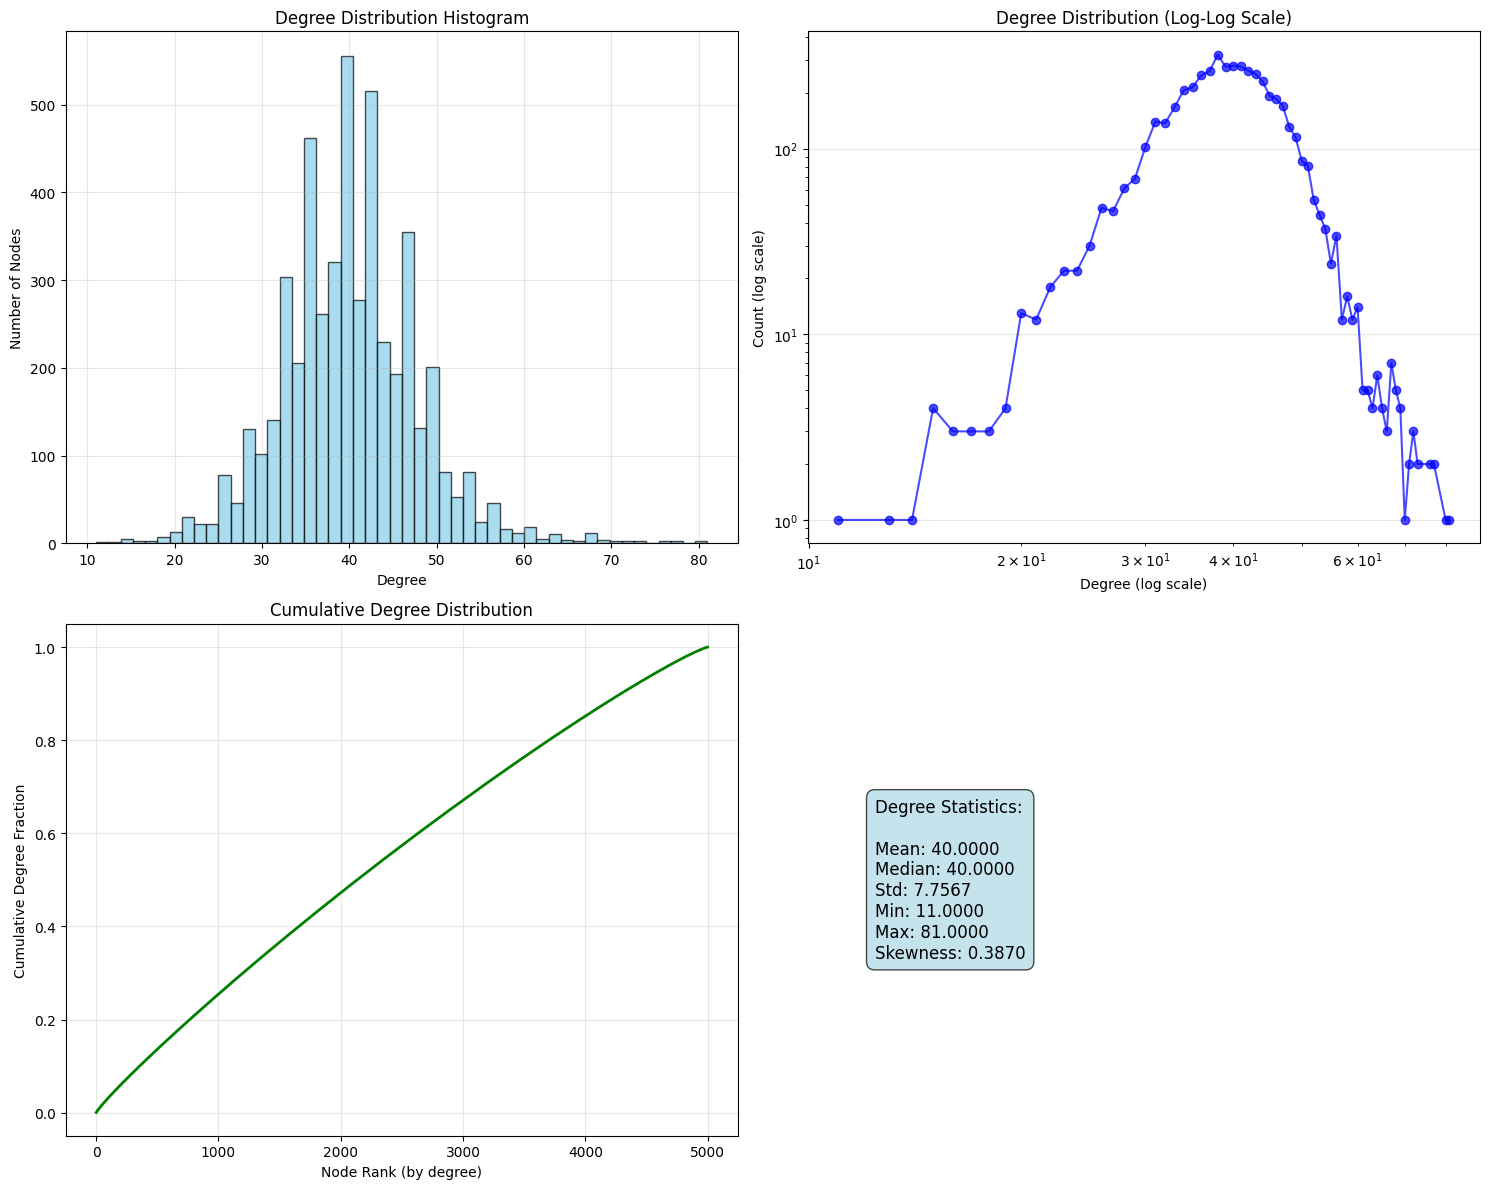

Mean degree: 40.00
Max degree: 81
Degree variance: 60.17

🎯 CENTRALITY MEASURES ANALYSIS
--------------------------------------------------
Calculating centrality measures...


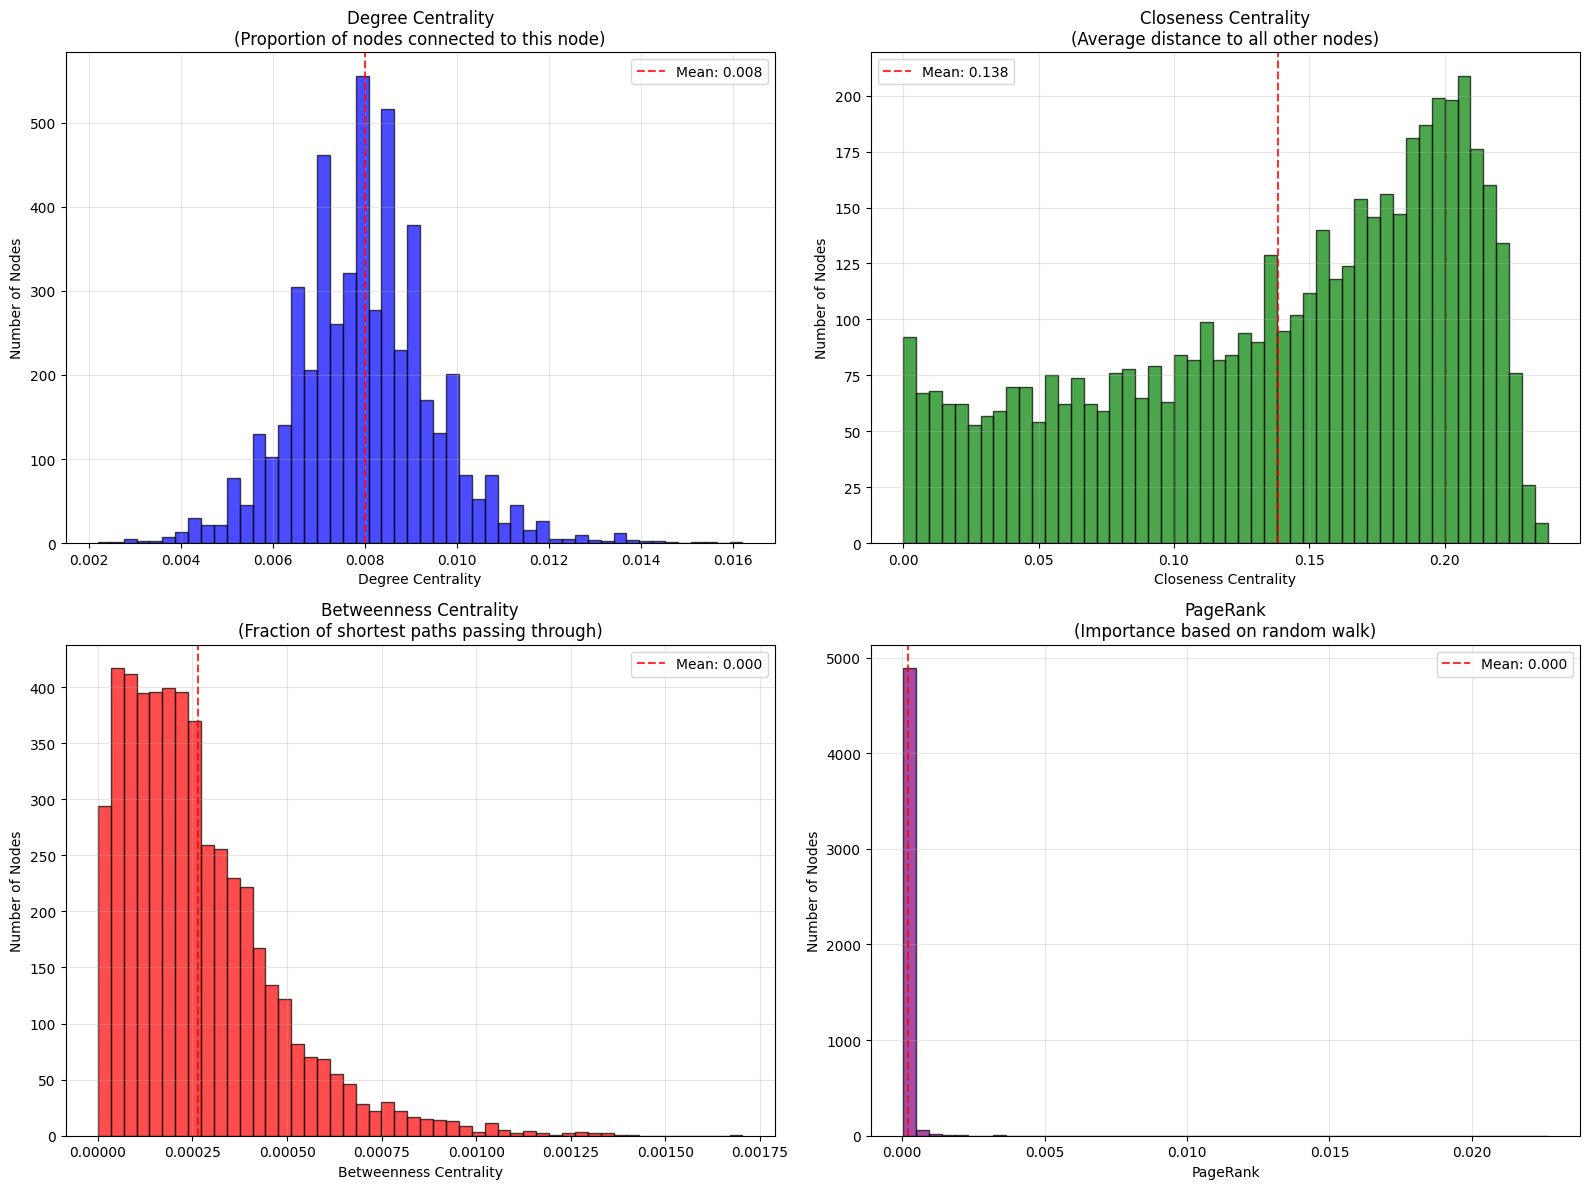


Top 5 nodes by each centrality measure:
----------------------------------------

Degree Centrality:
  concept4970: 0.0162
  concept4972: 0.0160
  concept4936: 0.0154
  concept4987: 0.0154
  concept4974: 0.0152

Closeness Centrality:
  concept4899: 0.2381
  concept4972: 0.2380
  concept4995: 0.2377
  concept4975: 0.2364
  concept4984: 0.2343

Betweenness Centrality:
  concept1884: 0.0017
  concept2738: 0.0014
  concept2418: 0.0014
  concept2618: 0.0014
  concept2754: 0.0014

PageRank:
  concept4999: 0.0227
  concept4998: 0.0123
  concept4997: 0.0088
  concept4996: 0.0068
  concept4995: 0.0058

🔗 CENTRALITY CORRELATIONS
------------------------------


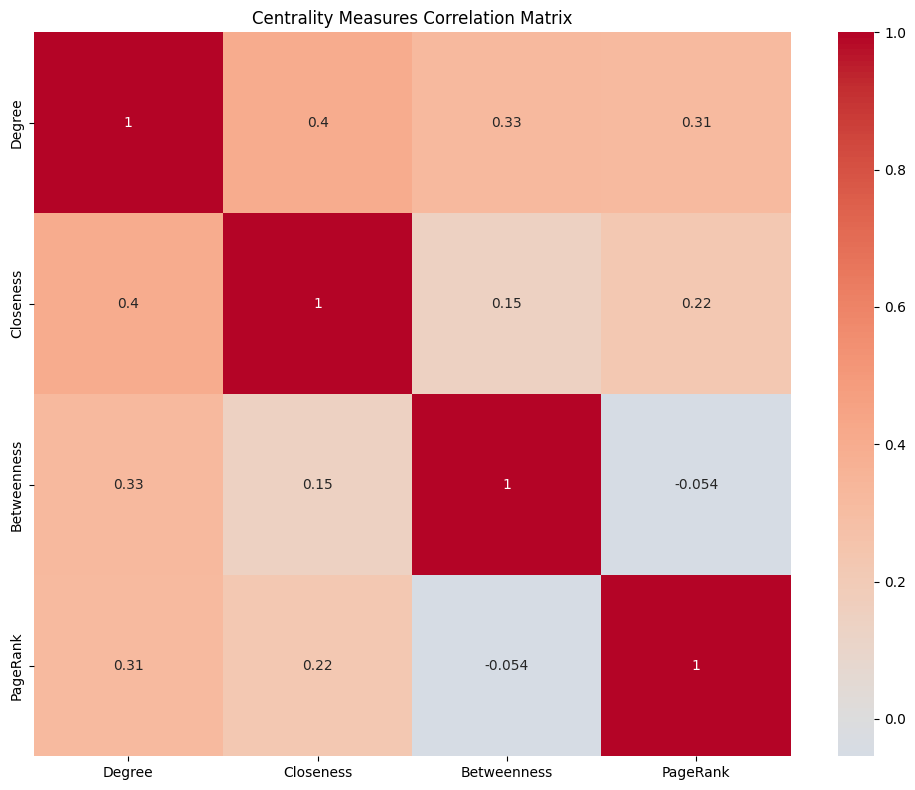

Key correlations:
  Degree ↔ PageRank: 0.314
  Closeness ↔ Betweenness: 0.150
  Degree ↔ Closeness: 0.403

🔗 CLUSTERING COEFFICIENT ANALYSIS
--------------------------------------------------
Clustering coefficient measures how well connected a node's neighbors are.
High clustering indicates local community structure.


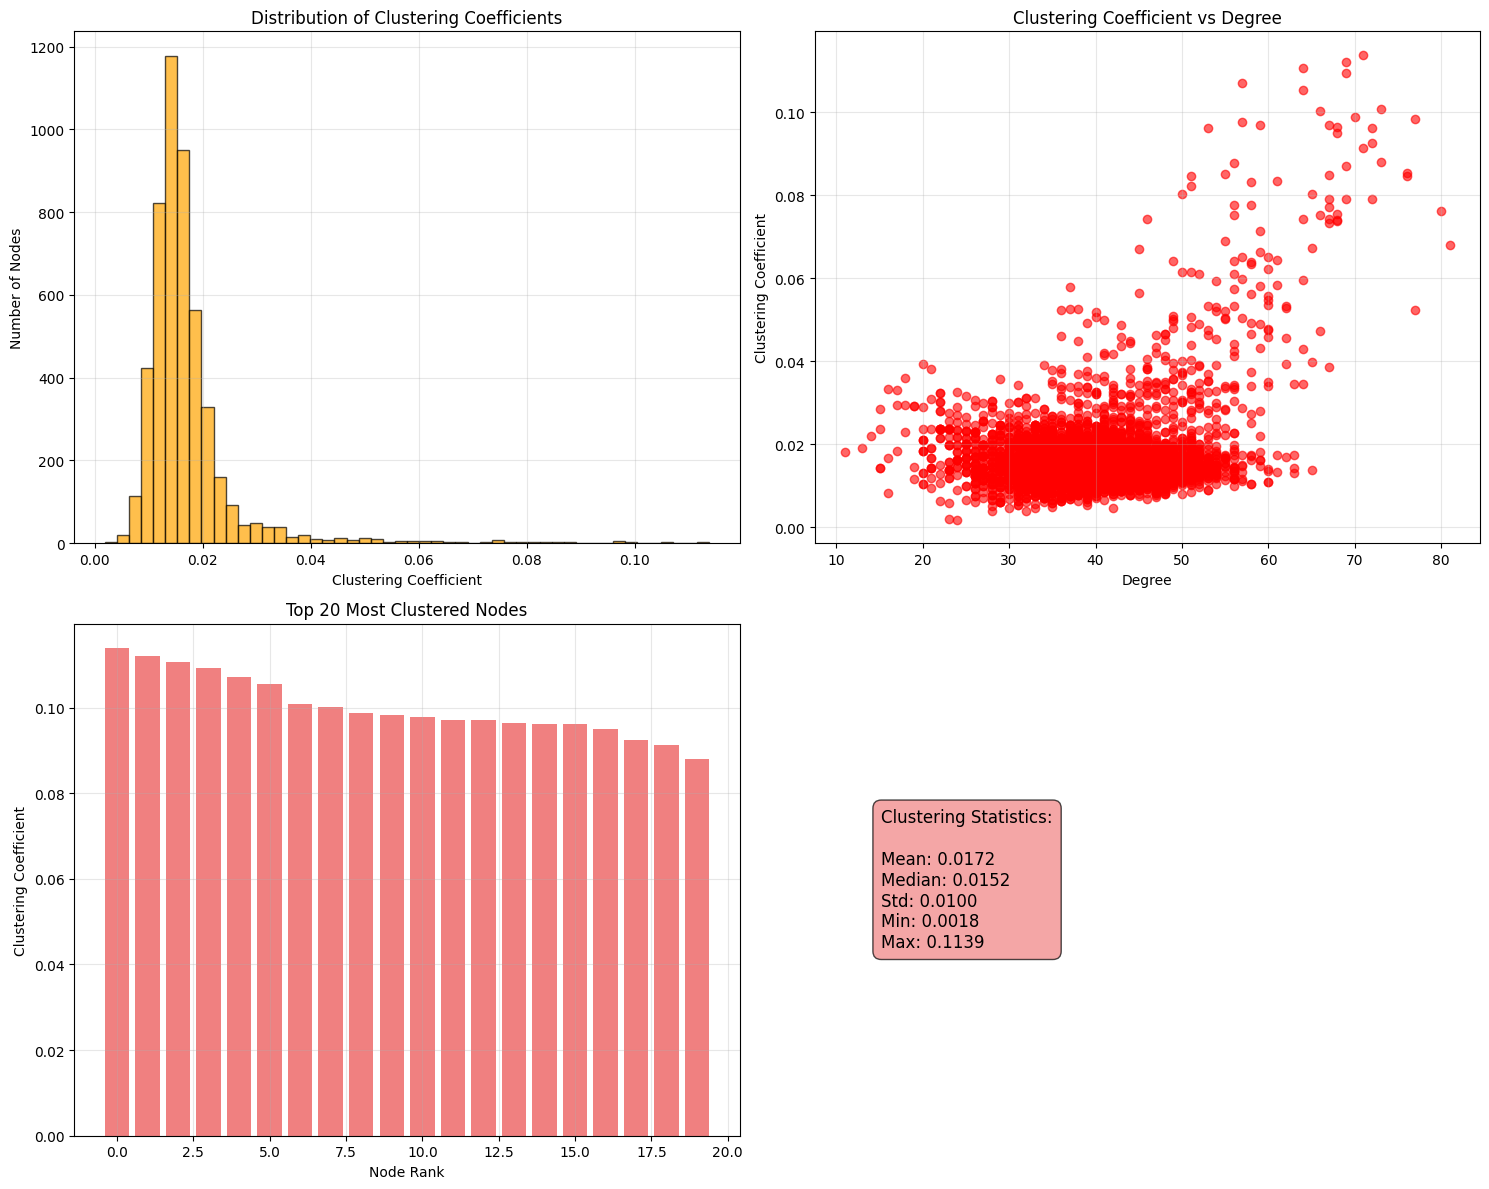

Average clustering coefficient: 0.0172
Maximum clustering coefficient: 0.1139

📊 COMPREHENSIVE GRAPH DASHBOARD
--------------------------------------------------


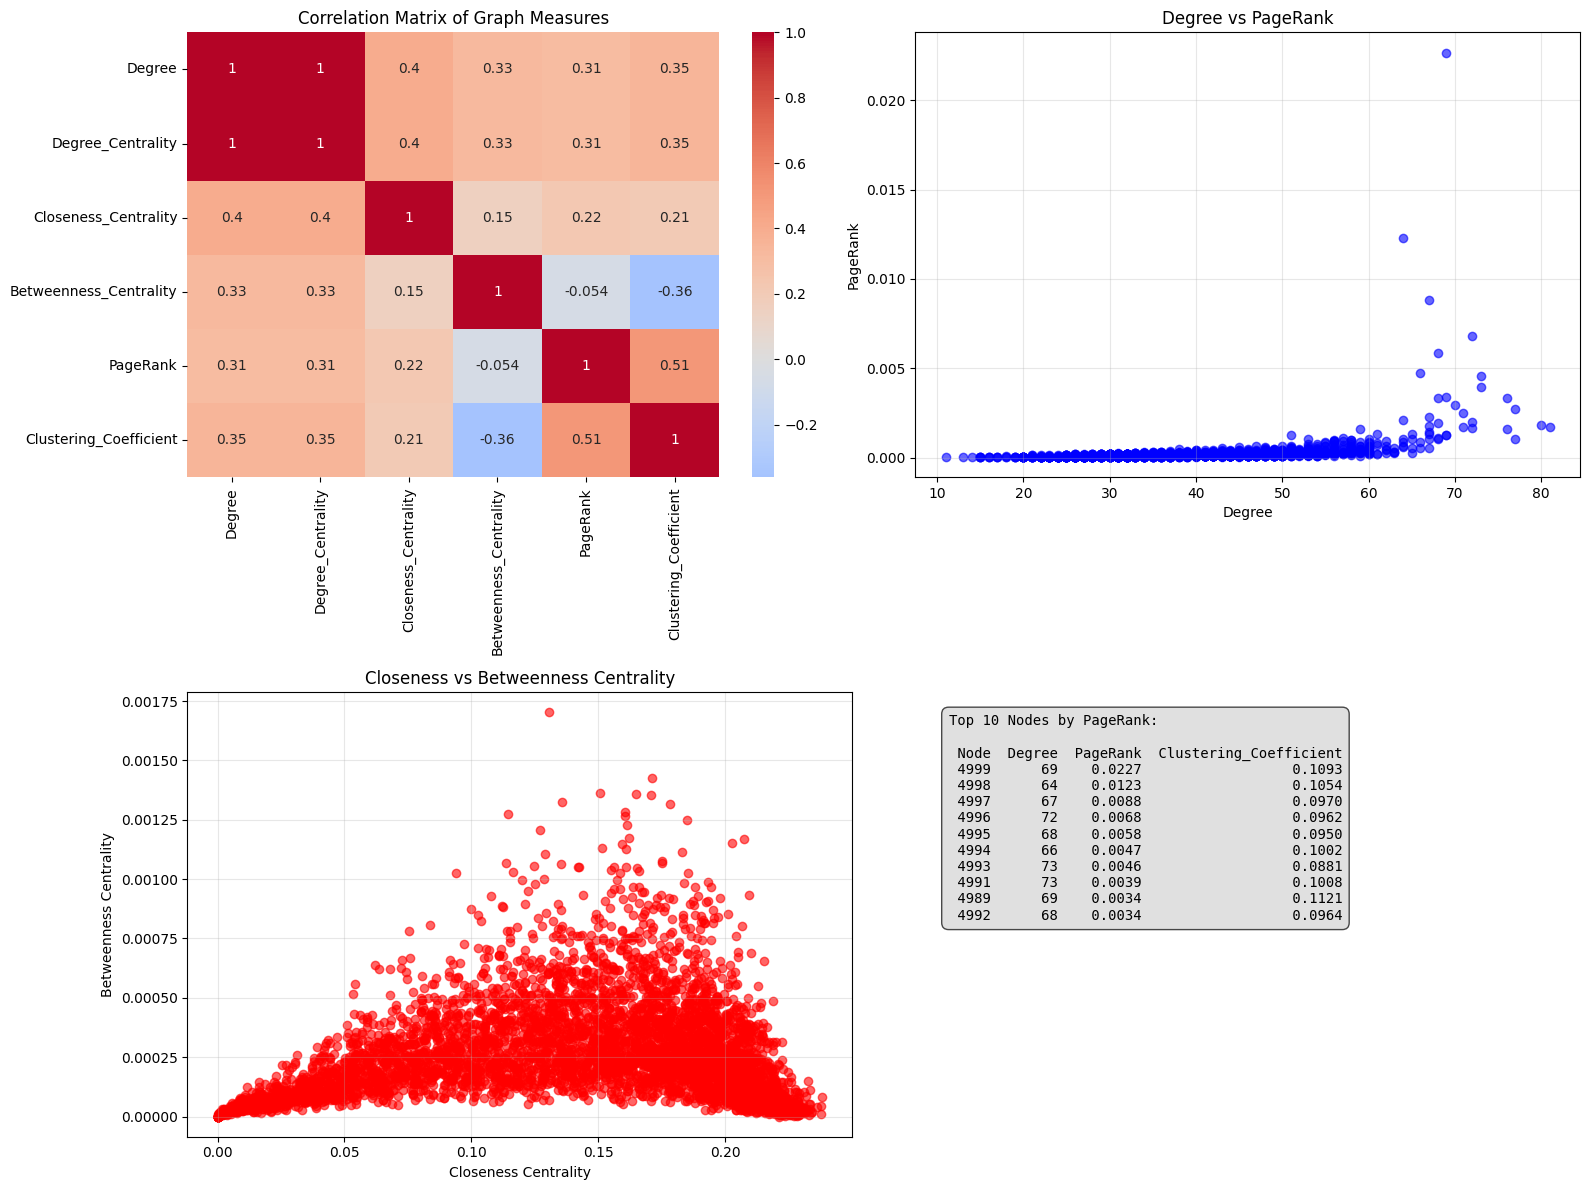

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
from typing import Dict, List, Tuple
import pandas as pd

class GraphAnalyzer:
    """
    Comprehensive graph analysis and visualization for ProsQA datasets.
    Explains and visualizes various graph metrics and centrality measures.
    """

    def __init__(self, generator):
        """Initialize with a SubProsQADataset instance."""
        self.generator = generator
        self.graph = generator.graph
        self.concepts = generator.concepts

    def analyze_and_visualize_all(self, save_path_prefix="graph_analysis"):
        """Run all analyses and create comprehensive visualizations."""
        print("="*80)
        print("COMPREHENSIVE GRAPH ANALYSIS")
        print("="*80)

        # Basic statistics
        self._print_basic_stats()

        # Create visualizations for list/dict outputs
        self._visualize_degree_distribution(save_path_prefix)
        self._visualize_centrality_measures(save_path_prefix)
        self._visualize_clustering_coefficients(save_path_prefix)
        self._create_comprehensive_dashboard(save_path_prefix)

    def _print_basic_stats(self):
        """Print basic graph statistics with explanations."""
        print("\n📊 BASIC GRAPH STATISTICS")
        print("-" * 50)

        print(f"Number of nodes: {self.graph.number_of_nodes()}")
        print(f"Number of edges: {self.graph.number_of_edges()}")
        print(f"Graph density: {nx.density(self.graph):.4f}")
        print(f"Average clustering coefficient: {nx.average_clustering(self.graph):.4f}")
        print(f"Transitivity: {nx.transitivity(self.graph):.4f}")
        print(f"Degree assortativity: {nx.degree_assortativity_coefficient(self.graph):.4f}")

        # Connected components
        components = list(nx.strongly_connected_components(self.graph))
        print(f"Number of connected components: {len(components)}")
        if len(components) > 1:
            component_sizes = [len(comp) for comp in components]
            print(f"Largest component size: {max(component_sizes)}")
            print(f"Smallest component size: {min(component_sizes)}")

        # Path statistics
        try:
            avg_path_length = nx.average_shortest_path_length(self.graph)
            print(f"Average shortest path length: {avg_path_length:.4f}")
        except:
            print("Average shortest path length: N/A (disconnected graph)")

        try:
            diameter = nx.diameter(self.graph)
            print(f"Graph diameter: {diameter}")
        except:
            print("Graph diameter: N/A (disconnected graph)")

    def _visualize_degree_distribution(self, save_path_prefix):
        """Visualize degree distribution with explanations."""
        print("\n📈 DEGREE DISTRIBUTION ANALYSIS")
        print("-" * 50)
        print("Degree distribution shows how many nodes have each degree value.")
        print("It helps understand the graph's structure and connectivity patterns.")

        degrees = [d for n, d in self.graph.degree()]
        degree_hist = nx.degree_histogram(self.graph)

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Degree histogram
        ax1.hist(degrees, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_xlabel('Degree')
        ax1.set_ylabel('Number of Nodes')
        ax1.set_title('Degree Distribution Histogram')
        ax1.grid(True, alpha=0.3)

        # 2. Log-log plot for power law detection
        non_zero_degrees = [d for d in degrees if d > 0]
        if non_zero_degrees:
            degree_counts = {}
            for d in non_zero_degrees:
                degree_counts[d] = degree_counts.get(d, 0) + 1

            degrees_sorted = sorted(degree_counts.keys())
            counts_sorted = [degree_counts[d] for d in degrees_sorted]

            ax2.loglog(degrees_sorted, counts_sorted, 'bo-', alpha=0.7)
            ax2.set_xlabel('Degree (log scale)')
            ax2.set_ylabel('Count (log scale)')
            ax2.set_title('Degree Distribution (Log-Log Scale)')
            ax2.grid(True, alpha=0.3)

        # 3. Cumulative degree distribution
        sorted_degrees = sorted(degrees, reverse=True)
        cumulative = np.cumsum(sorted_degrees) / np.sum(degrees)
        ax3.plot(range(len(cumulative)), cumulative, 'g-', linewidth=2)
        ax3.set_xlabel('Node Rank (by degree)')
        ax3.set_ylabel('Cumulative Degree Fraction')
        ax3.set_title('Cumulative Degree Distribution')
        ax3.grid(True, alpha=0.3)

        # 4. Degree statistics
        degree_stats = {
            'Mean': np.mean(degrees),
            'Median': np.median(degrees),
            'Std': np.std(degrees),
            'Min': np.min(degrees),
            'Max': np.max(degrees),
            'Skewness': self._calculate_skewness(degrees)
        }

        ax4.axis('off')
        stats_text = '\n'.join([f'{k}: {v:.4f}' for k, v in degree_stats.items()])
        ax4.text(0.1, 0.5, f'Degree Statistics:\n\n{stats_text}',
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.7))

        plt.tight_layout()
        plt.savefig(f'{save_path_prefix}_degree_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Mean degree: {degree_stats['Mean']:.2f}")
        print(f"Max degree: {degree_stats['Max']}")
        print(f"Degree variance: {degree_stats['Std']**2:.2f}")

    def _visualize_centrality_measures(self, save_path_prefix):
        """Visualize various centrality measures."""
        print("\n🎯 CENTRALITY MEASURES ANALYSIS")
        print("-" * 50)

        # Calculate centrality measures
        print("Calculating centrality measures...")
        degree_centrality = nx.degree_centrality(self.graph)
        closeness_centrality = nx.closeness_centrality(self.graph)
        betweenness_centrality = nx.betweenness_centrality(self.graph)
        pagerank = nx.pagerank(self.graph)

        # Create comprehensive visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Degree Centrality
        self._plot_centrality_histogram(ax1, degree_centrality, 'Degree Centrality', 'blue')
        ax1.set_title('Degree Centrality\n(Proportion of nodes connected to this node)')

        # 2. Closeness Centrality
        self._plot_centrality_histogram(ax2, closeness_centrality, 'Closeness Centrality', 'green')
        ax2.set_title('Closeness Centrality\n(Average distance to all other nodes)')

        # 3. Betweenness Centrality
        self._plot_centrality_histogram(ax3, betweenness_centrality, 'Betweenness Centrality', 'red')
        ax3.set_title('Betweenness Centrality\n(Fraction of shortest paths passing through)')

        # 4. PageRank
        self._plot_centrality_histogram(ax4, pagerank, 'PageRank', 'purple')
        ax4.set_title('PageRank\n(Importance based on random walk)')

        plt.tight_layout()
        plt.savefig(f'{save_path_prefix}_centrality_measures.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print top nodes for each centrality measure
        self._print_top_centrality_nodes(degree_centrality, closeness_centrality,
                                       betweenness_centrality, pagerank)

        # Correlation analysis
        self._analyze_centrality_correlations(degree_centrality, closeness_centrality,
                                            betweenness_centrality, pagerank, save_path_prefix)

    def _visualize_clustering_coefficients(self, save_path_prefix):
        """Visualize clustering coefficients."""
        print("\n🔗 CLUSTERING COEFFICIENT ANALYSIS")
        print("-" * 50)
        print("Clustering coefficient measures how well connected a node's neighbors are.")
        print("High clustering indicates local community structure.")

        clustering_coeffs = nx.clustering(self.graph)
        clustering_values = list(clustering_coeffs.values())

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Clustering coefficient histogram
        ax1.hist(clustering_values, bins=50, alpha=0.7, color='orange', edgecolor='black')
        ax1.set_xlabel('Clustering Coefficient')
        ax1.set_ylabel('Number of Nodes')
        ax1.set_title('Distribution of Clustering Coefficients')
        ax1.grid(True, alpha=0.3)

        # 2. Clustering vs Degree scatter plot
        degrees = [self.graph.degree(n) for n in self.graph.nodes()]
        ax2.scatter(degrees, clustering_values, alpha=0.6, color='red')
        ax2.set_xlabel('Degree')
        ax2.set_ylabel('Clustering Coefficient')
        ax2.set_title('Clustering Coefficient vs Degree')
        ax2.grid(True, alpha=0.3)

        # 3. Top clustered nodes
        top_clustered = sorted(clustering_coeffs.items(), key=lambda x: x[1], reverse=True)[:20]
        nodes, coeffs = zip(*top_clustered)
        ax3.bar(range(len(nodes)), coeffs, color='lightcoral')
        ax3.set_xlabel('Node Rank')
        ax3.set_ylabel('Clustering Coefficient')
        ax3.set_title('Top 20 Most Clustered Nodes')
        ax3.grid(True, alpha=0.3)

        # 4. Statistics
        stats = {
            'Mean': np.mean(clustering_values),
            'Median': np.median(clustering_values),
            'Std': np.std(clustering_values),
            'Min': np.min(clustering_values),
            'Max': np.max(clustering_values)
        }

        ax4.axis('off')
        stats_text = '\n'.join([f'{k}: {v:.4f}' for k, v in stats.items()])
        ax4.text(0.1, 0.5, f'Clustering Statistics:\n\n{stats_text}',
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightcoral', alpha=0.7))

        plt.tight_layout()
        plt.savefig(f'{save_path_prefix}_clustering_coefficients.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Average clustering coefficient: {stats['Mean']:.4f}")
        print(f"Maximum clustering coefficient: {stats['Max']:.4f}")

    def _create_comprehensive_dashboard(self, save_path_prefix):
        """Create a comprehensive dashboard with all measures."""
        print("\n📊 COMPREHENSIVE GRAPH DASHBOARD")
        print("-" * 50)

        # Calculate all measures
        degree_centrality = nx.degree_centrality(self.graph)
        closeness_centrality = nx.closeness_centrality(self.graph)
        betweenness_centrality = nx.betweenness_centrality(self.graph)
        pagerank = nx.pagerank(self.graph)
        clustering_coeffs = nx.clustering(self.graph)

        # Create DataFrame for analysis
        nodes = list(self.graph.nodes())
        data = {
            'Node': nodes,
            'Degree': [self.graph.degree(n) for n in nodes],
            'Degree_Centrality': [degree_centrality[n] for n in nodes],
            'Closeness_Centrality': [closeness_centrality[n] for n in nodes],
            'Betweenness_Centrality': [betweenness_centrality[n] for n in nodes],
            'PageRank': [pagerank[n] for n in nodes],
            'Clustering_Coefficient': [clustering_coeffs[n] for n in nodes]
        }

        df = pd.DataFrame(data)

        # Create correlation heatmap
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Correlation heatmap
        corr_matrix = df[['Degree', 'Degree_Centrality', 'Closeness_Centrality',
                         'Betweenness_Centrality', 'PageRank', 'Clustering_Coefficient']].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax1)
        ax1.set_title('Correlation Matrix of Graph Measures')

        # 2. Scatter plot: Degree vs PageRank
        ax2.scatter(df['Degree'], df['PageRank'], alpha=0.6, color='blue')
        ax2.set_xlabel('Degree')
        ax2.set_ylabel('PageRank')
        ax2.set_title('Degree vs PageRank')
        ax2.grid(True, alpha=0.3)

        # 3. Scatter plot: Closeness vs Betweenness
        ax3.scatter(df['Closeness_Centrality'], df['Betweenness_Centrality'], alpha=0.6, color='red')
        ax3.set_xlabel('Closeness Centrality')
        ax3.set_ylabel('Betweenness Centrality')
        ax3.set_title('Closeness vs Betweenness Centrality')
        ax3.grid(True, alpha=0.3)

        # 4. Top nodes summary
        top_nodes = df.nlargest(10, 'PageRank')[['Node', 'Degree', 'PageRank', 'Clustering_Coefficient']]
        ax4.axis('off')
        table_text = top_nodes.to_string(index=False, float_format='%.4f')
        ax4.text(0.05, 0.95, f'Top 10 Nodes by PageRank:\n\n{table_text}',
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.7))

        plt.tight_layout()
        plt.savefig(f'{save_path_prefix}_comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_centrality_histogram(self, ax, centrality_dict, title, color):
        """Helper function to plot centrality histogram."""
        values = list(centrality_dict.values())
        ax.hist(values, bins=50, alpha=0.7, color=color, edgecolor='black')
        ax.set_xlabel(title)
        ax.set_ylabel('Number of Nodes')
        ax.grid(True, alpha=0.3)

        # Add statistics
        mean_val = np.mean(values)
        std_val = np.std(values)
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.3f}')
        ax.legend()

    def _print_top_centrality_nodes(self, degree_cent, closeness_cent, betweenness_cent, pagerank):
        """Print top nodes for each centrality measure."""
        print("\nTop 5 nodes by each centrality measure:")
        print("-" * 40)

        measures = [
            ('Degree Centrality', degree_cent),
            ('Closeness Centrality', closeness_cent),
            ('Betweenness Centrality', betweenness_cent),
            ('PageRank', pagerank)
        ]

        for measure_name, measure_dict in measures:
            top_nodes = sorted(measure_dict.items(), key=lambda x: x[1], reverse=True)[:5]
            print(f"\n{measure_name}:")
            for node, value in top_nodes:
                concept_name = self.concepts[node] if node < len(self.concepts) else f"Node_{node}"
                print(f"  {concept_name}: {value:.4f}")

    def _analyze_centrality_correlations(self, degree_cent, closeness_cent, betweenness_cent, pagerank, save_path_prefix):
        """Analyze correlations between centrality measures."""
        print("\n🔗 CENTRALITY CORRELATIONS")
        print("-" * 30)

        # Create correlation plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        measures = {
            'Degree': degree_cent,
            'Closeness': closeness_cent,
            'Betweenness': betweenness_cent,
            'PageRank': pagerank
        }

        # Calculate correlations
        nodes = list(self.graph.nodes())
        corr_data = {}
        for name, measure in measures.items():
            corr_data[name] = [measure[n] for n in nodes]

        corr_df = pd.DataFrame(corr_data)
        corr_matrix = corr_df.corr()

        # Plot heatmap
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax)
        ax.set_title('Centrality Measures Correlation Matrix')

        plt.tight_layout()
        plt.savefig(f'{save_path_prefix}_centrality_correlations.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print correlation insights
        print("Key correlations:")
        print(f"  Degree ↔ PageRank: {corr_matrix.loc['Degree', 'PageRank']:.3f}")
        print(f"  Closeness ↔ Betweenness: {corr_matrix.loc['Closeness', 'Betweenness']:.3f}")
        print(f"  Degree ↔ Closeness: {corr_matrix.loc['Degree', 'Closeness']:.3f}")

    def _calculate_skewness(self, data):
        """Calculate skewness of data."""
        mean = np.mean(data)
        std = np.std(data)
        if std == 0:
            return 0
        return np.mean([(x - mean) ** 3 for x in data]) / (std ** 3)

    def explain_measures(self):
        """Print detailed explanations of all graph measures."""
        print("\n" + "="*80)
        print("DETAILED EXPLANATION OF GRAPH MEASURES")
        print("="*80)

        explanations = {
            "Degree Distribution": """
            The degree distribution shows how many nodes have each degree value.
            - Degree = number of connections a node has
            - Helps identify if the graph follows a power law (scale-free)
            - Power law graphs have few highly connected "hub" nodes
            - Random graphs have Poisson-like degree distributions
            """,

            "Degree Centrality": """
            Degree centrality measures the number of direct connections a node has.
            - Formula: degree(node) / (total_nodes - 1)
            - Range: [0, 1]
            - High value = well-connected node
            - Simple but effective measure of local importance
            """,

            "Closeness Centrality": """
            Closeness centrality measures how close a node is to all other nodes.
            - Formula: (n-1) / sum(shortest_path_lengths_to_all_other_nodes)
            - Range: [0, 1]
            - High value = node can reach others quickly
            - Good for identifying "central" nodes in communication networks
            """,

            "Betweenness Centrality": """
            Betweenness centrality measures how often a node lies on shortest paths.
            - Formula: sum(shortest_paths_through_node / total_shortest_paths)
            - Range: [0, 1]
            - High value = node is a "bridge" or "bottleneck"
            - Important for identifying critical nodes in network flow
            """,

            "PageRank": """
            PageRank measures node importance based on random walk behavior.
            - Considers both quantity and quality of connections
            - Damping factor prevents random walk from getting stuck
            - Range: [0, 1] (sums to 1 across all nodes)
            - High value = node is "important" in the network
            - Used by Google for web page ranking
            """,

            "Clustering Coefficient": """
            Clustering coefficient measures local community structure.
            - Formula: actual_edges_between_neighbors / possible_edges_between_neighbors
            - Range: [0, 1]
            - High value = node's neighbors are well-connected to each other
            - Indicates presence of local communities or cliques
            - Global average = transitivity of the entire graph
            """,

            "Transitivity": """
            Transitivity measures the overall clustering tendency of the graph.
            - Formula: 3 * number_of_triangles / number_of_connected_triples
            - Range: [0, 1]
            - High value = graph has many triangles (A-B-C-A patterns)
            - Indicates strong community structure
            """,

            "Degree Assortativity": """
            Degree assortativity measures whether nodes connect to similar-degree nodes.
            - Range: [-1, 1]
            - Positive = high-degree nodes connect to other high-degree nodes
            - Negative = high-degree nodes connect to low-degree nodes
            - Zero = random mixing
            - Affects network resilience and information flow
            """
        }

        for measure, explanation in explanations.items():
            print(f"\n {measure}")
            print("-" * (len(measure) - 2))
            print(explanation.strip())


# Example usage
if __name__ == "__main__":
    # from generate_shared_graph_cot_2 import SubProsQADataset

    # Create a sample dataset
    graph_dataset = SubProsQADataset(
        num_nodes=5000,
        num_edges=100000,
        num_samples=5000,
        num_context_edges=20,
        representation='structured',
        candidate_samples_path='candidate_samples.json',
        load_candidate_samples=False,
        dataset_path='prosqa_dataset.json',
        load_dataset=False,
        depth_range=(3, 6),
        seed=42
    )

    # Create analyzer and run comprehensive analysis
    analyzer = GraphAnalyzer(graph_dataset)

    # Print explanations
    analyzer.explain_measures()

    # Run all analyses and visualizations
    analyzer.analyze_and_visualize_all("prosqa_graph_analysis")

Generated candidate samples with target paths for 100 / 100 random nodes in graph!
Created 0/100 samples...
Created 5/100 samples...
Created 10/100 samples...
Created 15/100 samples...
Created 20/100 samples...
Created 25/100 samples...
Created 30/100 samples...
Created 35/100 samples...
Created 40/100 samples...
Created 45/100 samples...
Created 50/100 samples...
Created 55/100 samples...
Created 60/100 samples...
Created 65/100 samples...
Created 70/100 samples...
Created 75/100 samples...
Created 80/100 samples...
Created 85/100 samples...
Created 90/100 samples...
Created 95/100 samples...
Successfully created dataset with 100 samples!
Dataset statistics:
  num_samples: 100
  avg_path_length: 3.98
  min_path_length: 3
  max_path_length: 6
Saving dataset to prosqa_dataset.json...
Dataset saved with 100 samples!
Graph created: 100 nodes, 300 edges
Graph statistics:
  Number of nodes: 100
  Number of edges: 300
  Number of components: 100
  Average clustering coefficient: 0.1133391053

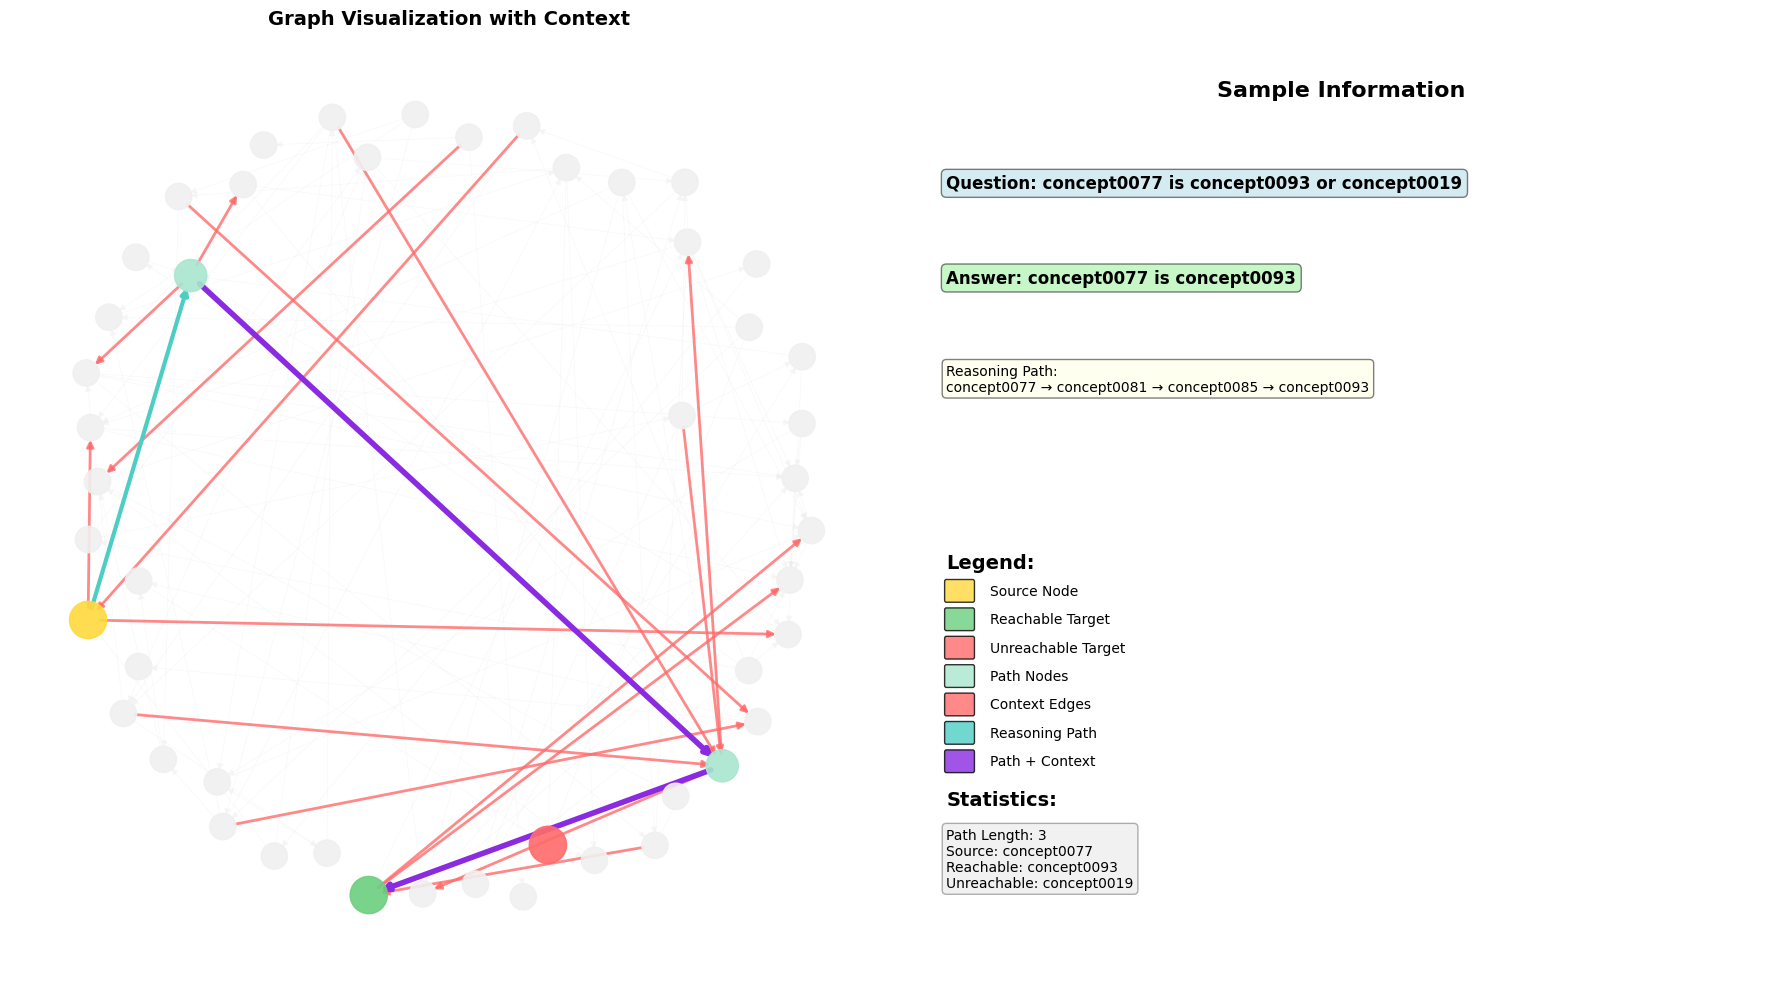


Generating multiple samples...


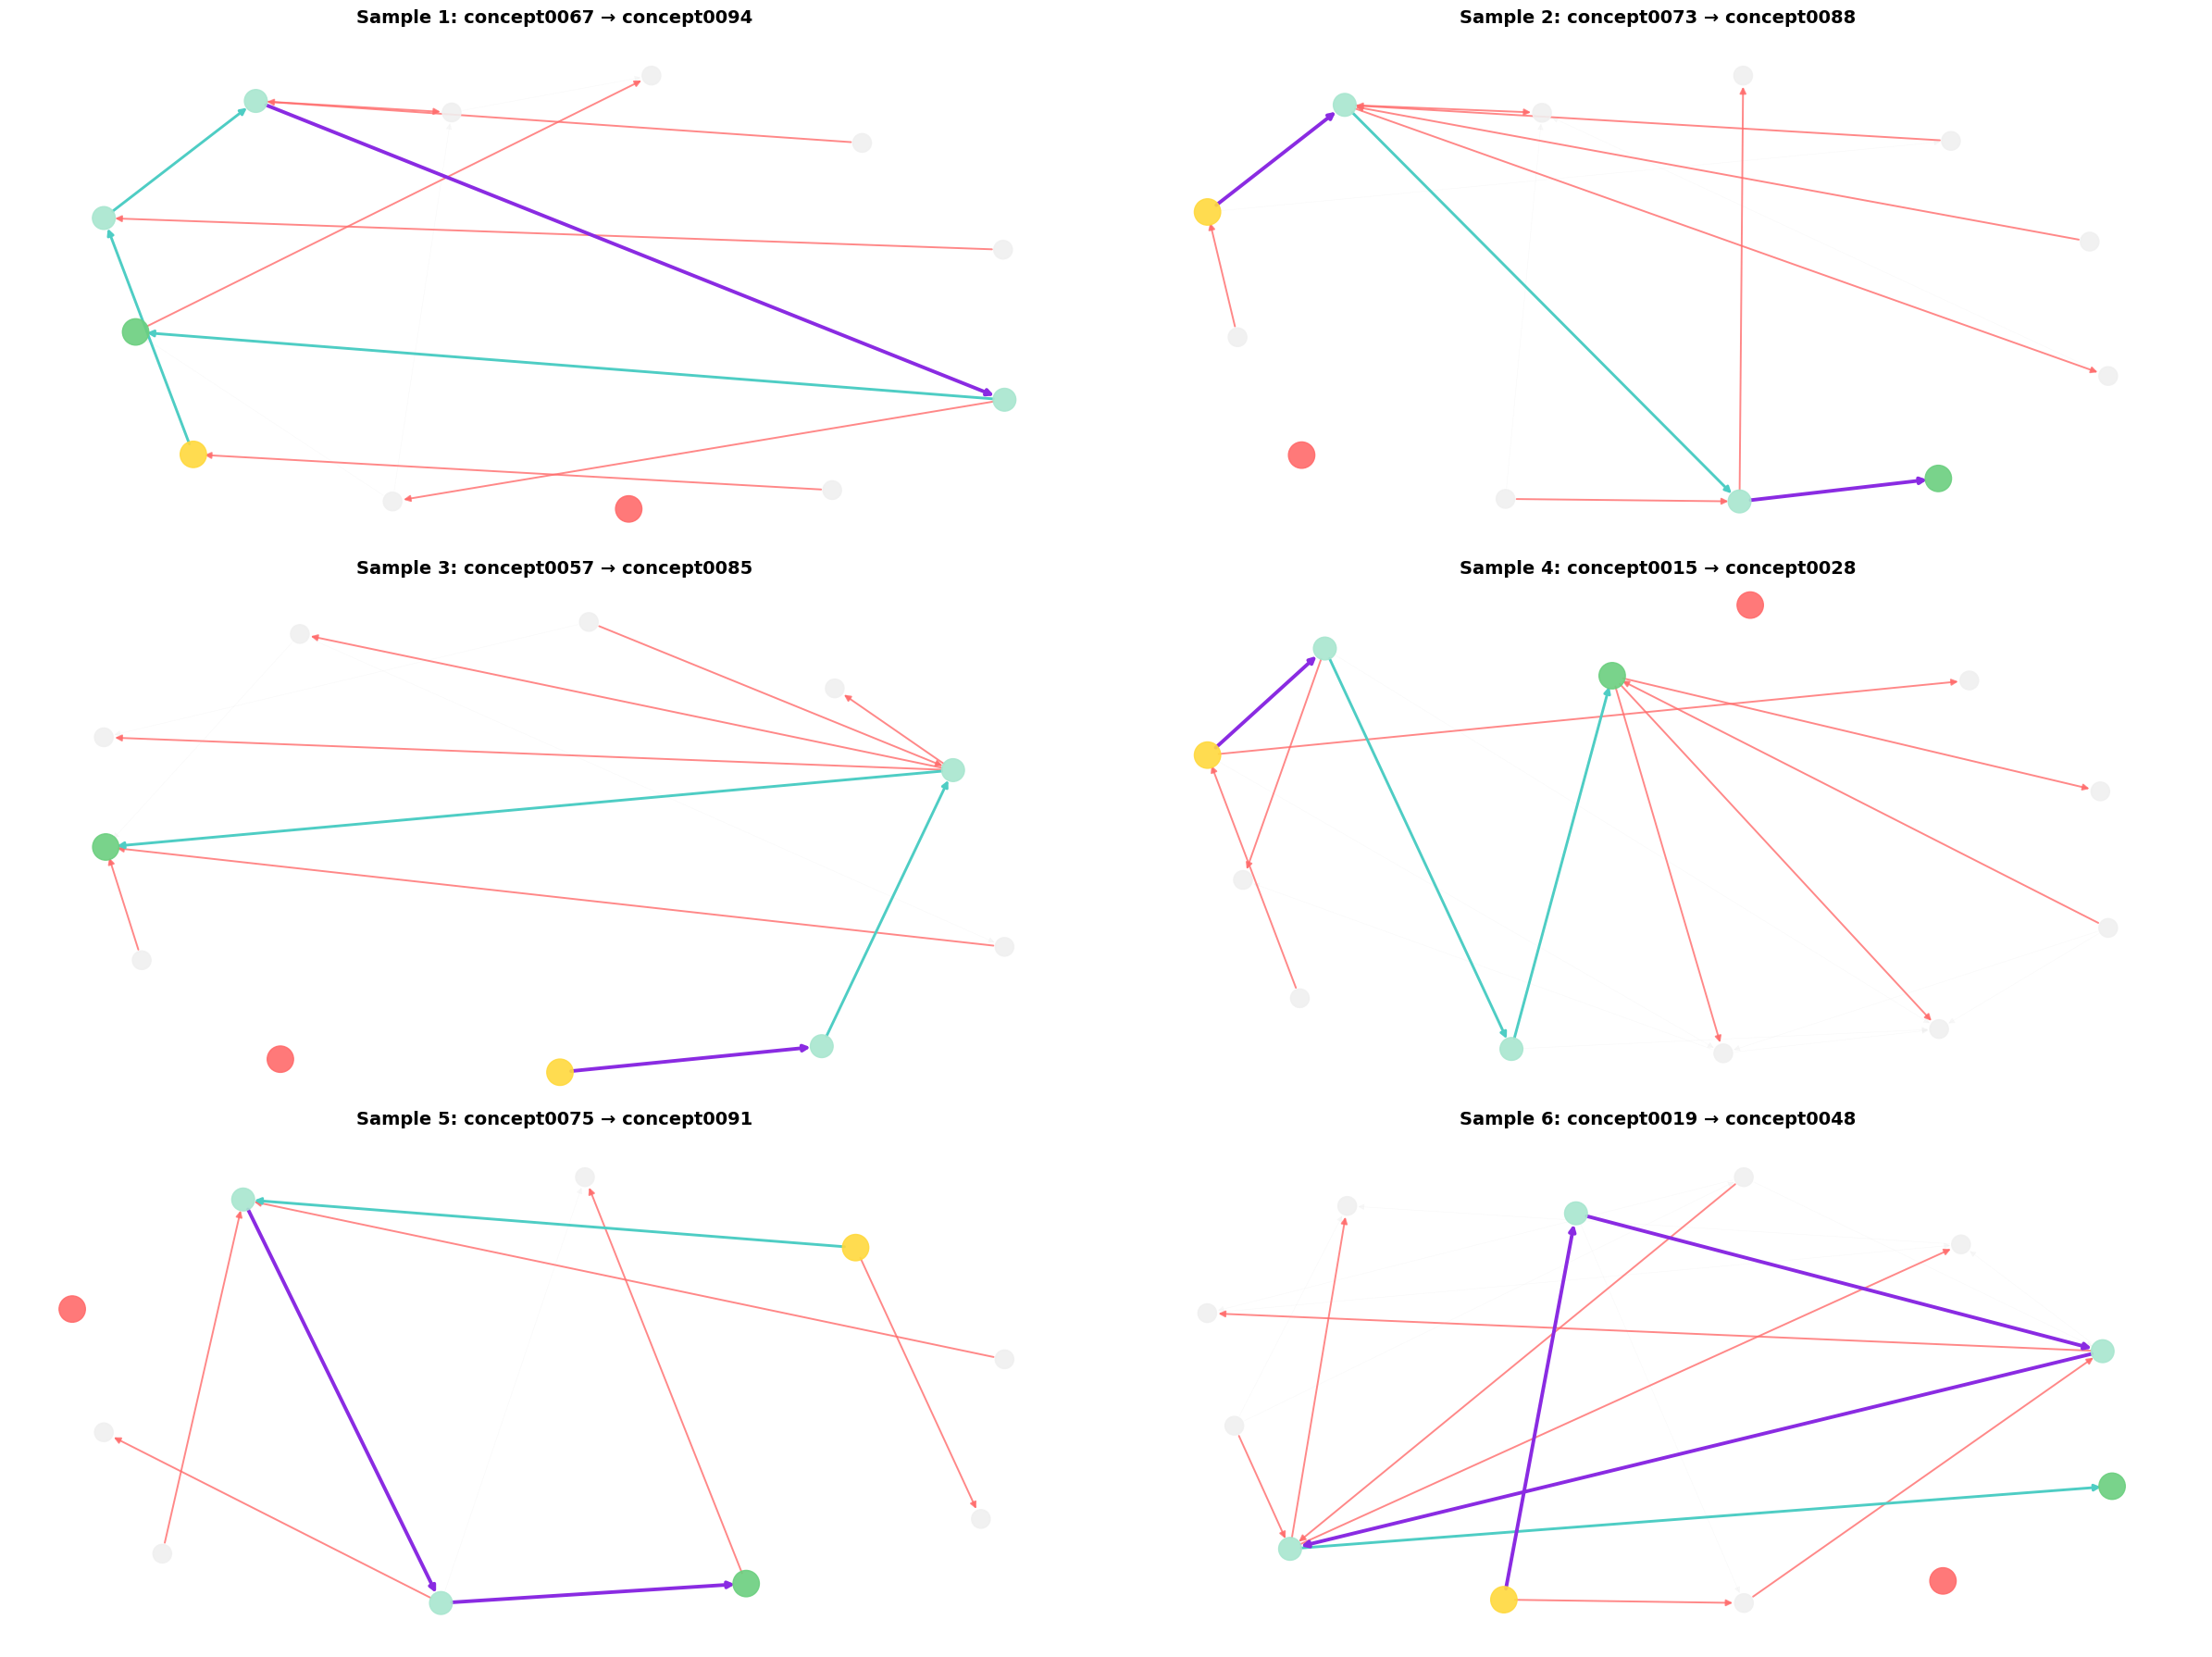

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import FancyBboxPatch
import random
from typing import List, Tuple, Dict, Set

class ProsQAGraphVisualizer:
    """
    Visualize ProsQA graphs with highlighted context edges, reasoning paths,
    and question nodes.
    """

    def __init__(self, generator):
        """Initialize with a ProsQAGenerator instance."""
        self.generator = generator
        self.graph = generator.graph
        self.concepts = generator.concepts

        # Color scheme
        self.colors = {
            'context_edge': '#FF6B6B',      # Red for context edges
            'reasoning_path': '#4ECDC4',     # Teal for reasoning path
            'path_and_context': '#8A2BE2',  # Purple for edges both on path and in context
            'other_edge': '#E8E8E8',        # Light gray for other edges
            'source_node': '#FFD93D',       # Yellow for source
            'reachable_target': '#6BCF7F',   # Green for reachable target
            'unreachable_target': '#FF6B6B', # Red for unreachable target
            'path_node': '#A8E6CF',         # Light green for path nodes
            'other_node': '#F0F0F0'         # Light gray for other nodes
        }

    def visualize_sample(self, sample_data=None, figsize=(16, 12),
                        layout='spring', node_size_scale=1.0,
                        show_labels=True, label_font_size=8,
                        edge_width_scale=1.0, save_path=None):
        """
        Visualize a single sample showing context edges, reasoning path, and key nodes.

        Args:
            sample_data: Dict containing sample info, or None to generate new sample
            figsize: Figure size tuple
            layout: Layout algorithm ('spring', 'circular', 'kamada_kawai', 'shell')
            node_size_scale: Scale factor for node sizes
            show_labels: Whether to show node labels
            label_font_size: Font size for labels
            edge_width_scale: Scale factor for edge widths
            save_path: Path to save figure (optional)
        """

        # Extract information from sample
        source_concept = sample_data['source']
        reachable_concept = sample_data['reachable_target']
        unreachable_concept = sample_data['unreachable_target']
        reasoning_path = sample_data['path']

        # Get node indices
        source_idx = self.concepts.index(source_concept)
        reachable_idx = self.concepts.index(reachable_concept)
        unreachable_idx = self.concepts.index(unreachable_concept)
        path_indices = [self.concepts.index(concept) for concept in reasoning_path]

        # Get context edges from the structured context
        context_edges = self._extract_context_edges(sample_data['context'])

        # Create subgraph containing relevant nodes
        relevant_nodes = set()
        relevant_nodes.update(path_indices)
        relevant_nodes.add(unreachable_idx)

        # Add nodes connected by context edges
        for u, v in context_edges:
            relevant_nodes.add(u)
            relevant_nodes.add(v)

        # Add some random neighboring nodes for context
        for node in list(relevant_nodes)[:]:
            neighbors = list(self.graph.predecessors(node)) + list(self.graph.successors(node))
            relevant_nodes.update(random.sample(neighbors, min(3, len(neighbors))))

        # Limit graph size for visualization
        if len(relevant_nodes) > 100:
            # Keep most important nodes
            important_nodes = set(path_indices + [unreachable_idx])
            context_nodes = set()
            for u, v in context_edges:
                context_nodes.update([u, v])

            other_nodes = relevant_nodes - important_nodes - context_nodes
            other_nodes = set(random.sample(list(other_nodes),
                                          min(50, len(other_nodes))))

            relevant_nodes = important_nodes | context_nodes | other_nodes

        # Create subgraph
        subgraph = self.graph.subgraph(relevant_nodes)

        # Set up the plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Left plot: Full context visualization
        self._plot_graph(subgraph, ax1, source_idx, reachable_idx, unreachable_idx,
                        path_indices, context_edges, layout, node_size_scale,
                        show_labels, label_font_size, edge_width_scale,
                        title="Graph Visualization with Context")

        # Right plot: Legend and sample information
        self._plot_sample_info(ax2, sample_data)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        return fig

    def _extract_context_edges(self, context_str):
        """Extract edge tuples from structured context string."""
        edges = []
        if context_str.startswith('[EDGES]'):
            edge_part = context_str[7:].strip()
            if '[FACTS]' in edge_part:
                edge_part = edge_part.split('[FACTS]')[0].strip()

            edge_strings = [e.strip() for e in edge_part.split(',') if '->' in e]

            for edge_str in edge_strings:
                if '->' in edge_str:
                    u_name, v_name = edge_str.split('->')
                    u_name, v_name = u_name.strip(), v_name.strip()
                    try:
                        u_idx = self.concepts.index(u_name)
                        v_idx = self.concepts.index(v_name)
                        edges.append((u_idx, v_idx))
                    except ValueError:
                        continue

        return edges

    def _plot_graph(self, graph, ax, source_idx, reachable_idx, unreachable_idx,
                   path_indices, context_edges, layout, node_size_scale,
                   show_labels, label_font_size, edge_width_scale, title):
        """Plot the graph with highlighting."""

        # Generate layout
        if layout == 'spring':
            pos = nx.spring_layout(graph, k=3, iterations=50, seed=42)
        elif layout == 'circular':
            pos = nx.circular_layout(graph)
        elif layout == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(graph)
        elif layout == 'shell':
            pos = nx.shell_layout(graph)
        else:
            pos = nx.spring_layout(graph, seed=42)

        # Categorize edges
        context_edge_set = set(context_edges)
        reasoning_edges = set(zip(path_indices[:-1], path_indices[1:]))

        # Find edges that are both on the path and in context
        path_and_context_edges = reasoning_edges.intersection(context_edge_set)

        # Remove path_and_context_edges from other categories to avoid double drawing
        context_only_edges = context_edge_set - path_and_context_edges
        reasoning_only_edges = reasoning_edges - path_and_context_edges

        # Draw edges with different styles
        all_edges = list(graph.edges())

        # Other edges (background)
        other_edges = [(u, v) for u, v in all_edges
                      if (u, v) not in context_edge_set and (u, v) not in reasoning_edges]
        if other_edges:
            nx.draw_networkx_edges(graph, pos, edgelist=other_edges,
                                 edge_color=self.colors['other_edge'],
                                 width=0.5 * edge_width_scale, alpha=0.3, ax=ax)

        # Context-only edges (red)
        context_only_edges_in_graph = [(u, v) for u, v in context_only_edges if graph.has_edge(u, v)]
        if context_only_edges_in_graph:
            nx.draw_networkx_edges(graph, pos, edgelist=context_only_edges_in_graph,
                                 edge_color=self.colors['context_edge'],
                                 width=2 * edge_width_scale, alpha=0.8, ax=ax)

        # Reasoning-only edges (teal)
        reasoning_only_edges_in_graph = [(u, v) for u, v in reasoning_only_edges if graph.has_edge(u, v)]
        if reasoning_only_edges_in_graph:
            nx.draw_networkx_edges(graph, pos, edgelist=reasoning_only_edges_in_graph,
                                 edge_color=self.colors['reasoning_path'],
                                 width=3 * edge_width_scale, alpha=1.0, ax=ax,
                                 style='solid')

        # Edges that are both on path and in context (purple)
        path_and_context_edges_in_graph = [(u, v) for u, v in path_and_context_edges if graph.has_edge(u, v)]
        if path_and_context_edges_in_graph:
            nx.draw_networkx_edges(graph, pos, edgelist=path_and_context_edges_in_graph,
                                 edge_color=self.colors['path_and_context'],
                                 width=4 * edge_width_scale, alpha=1.0, ax=ax,
                                 style='solid')

        # Categorize and draw nodes
        nodes = list(graph.nodes())
        node_colors = []
        node_sizes = []

        for node in nodes:
            base_size = 300 * node_size_scale

            if node == source_idx:
                node_colors.append(self.colors['source_node'])
                node_sizes.append(base_size * 2)
            elif node == reachable_idx:
                node_colors.append(self.colors['reachable_target'])
                node_sizes.append(base_size * 2)
            elif node == unreachable_idx:
                node_colors.append(self.colors['unreachable_target'])
                node_sizes.append(base_size * 2)
            elif node in path_indices:
                node_colors.append(self.colors['path_node'])
                node_sizes.append(base_size * 1.5)
            else:
                node_colors.append(self.colors['other_node'])
                node_sizes.append(base_size)

        # Draw nodes
        nx.draw_networkx_nodes(graph, pos, node_color=node_colors,
                             node_size=node_sizes, alpha=0.9, ax=ax)

        # Add labels if requested
        if show_labels:
            labels = {node: self.concepts[node] for node in nodes}
            nx.draw_networkx_labels(graph, pos, labels, font_size=label_font_size, ax=ax)

        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.axis('off')

    def _plot_sample_info(self, ax, sample_data):
        """Plot sample information and legend."""
        ax.axis('off')

        # Title
        ax.text(0.5, 0.95, 'Sample Information', ha='center', va='top',
                fontsize=16, fontweight='bold', transform=ax.transAxes)

        # Question
        question_text = f"Question: {sample_data['question']}"
        ax.text(0.05, 0.85, question_text, ha='left', va='top',
                fontsize=12, fontweight='bold', transform=ax.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.5))

        # Answer
        answer_text = f"Answer: {sample_data['answer']}"
        ax.text(0.05, 0.75, answer_text, ha='left', va='top',
                fontsize=12, fontweight='bold', transform=ax.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.5))

        # Reasoning path
        path_text = f"Reasoning Path:\n{' → '.join(sample_data['path'])}"
        ax.text(0.05, 0.65, path_text, ha='left', va='top',
                fontsize=10, transform=ax.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.5))

        # Legend
        legend_y = 0.45
        ax.text(0.05, legend_y, 'Legend:', ha='left', va='top',
                fontsize=14, fontweight='bold', transform=ax.transAxes)

        legend_items = [
            ('Source Node', self.colors['source_node']),
            ('Reachable Target', self.colors['reachable_target']),
            ('Unreachable Target', self.colors['unreachable_target']),
            ('Path Nodes', self.colors['path_node']),
            ('Context Edges', self.colors['context_edge']),
            ('Reasoning Path', self.colors['reasoning_path']),
            ('Path + Context', self.colors['path_and_context']),
        ]

        y_offset = 0.03
        for i, (label, color) in enumerate(legend_items):
            y_pos = legend_y - 0.04 - (i * y_offset)

            # Draw colored square
            rect = FancyBboxPatch((0.05, y_pos - 0.01), 0.03, 0.02,
                                boxstyle="round,pad=0.002",
                                facecolor=color, alpha=0.8,
                                transform=ax.transAxes)
            ax.add_patch(rect)

            # Add label
            ax.text(0.1, y_pos, label, ha='left', va='center',
                    fontsize=10, transform=ax.transAxes)

        # Statistics
        stats_y = legend_y - 0.25
        ax.text(0.05, stats_y, 'Statistics:', ha='left', va='top',
                fontsize=14, fontweight='bold', transform=ax.transAxes)

        stats_text = f"""Path Length: {sample_data['path_length']}
Source: {sample_data['source']}
Reachable: {sample_data['reachable_target']}
Unreachable: {sample_data['unreachable_target']}"""

        ax.text(0.05, stats_y - 0.04, stats_text, ha='left', va='top',
                fontsize=10, transform=ax.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.3))

    def visualize_multiple_samples(self, num_samples=4, figsize=(20, 16),
                                 save_path=None):
        """Visualize multiple samples in a grid."""
        rows = int(np.ceil(num_samples / 2))
        fig, axes = plt.subplots(rows, 2, figsize=figsize)
        if rows == 1:
            axes = axes.reshape(1, -1)

        for i in range(num_samples):
            row, col = i // 2, i % 2

            sample = self.generator.create_sample()
            if sample is None:
                axes[row, col].text(0.5, 0.5, "Failed to generate sample",
                                  ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].axis('off')
                continue

            # Create mini visualization
            source_idx = self.concepts.index(sample['source'])
            reachable_idx = self.concepts.index(sample['reachable_target'])
            unreachable_idx = self.concepts.index(sample['unreachable_target'])
            path_indices = [self.concepts.index(concept) for concept in sample['path']]
            context_edges = self._extract_context_edges(sample['context'])

            # Get relevant nodes for subgraph
            relevant_nodes = set(path_indices + [unreachable_idx])
            for u, v in context_edges[:10]:  # Limit context edges for clarity
                relevant_nodes.update([u, v])

            if len(relevant_nodes) > 30:
                # Keep most important nodes
                important = set(path_indices + [unreachable_idx])
                others = list(relevant_nodes - important)
                others = set(random.sample(others, min(20, len(others))))
                relevant_nodes = important | others

            subgraph = self.graph.subgraph(relevant_nodes)

            self._plot_graph(subgraph, axes[row, col], source_idx, reachable_idx,
                           unreachable_idx, path_indices, context_edges[:10],
                           'spring', 0.7, False, 8, 0.7,
                           f"Sample {i+1}: {sample['source']} → {sample['reachable_target']}")

        # Remove empty subplots
        for i in range(num_samples, rows * 2):
            row, col = i // 2, i % 2
            fig.delaxes(axes[row, col])

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        return fig


# Example usage
if __name__ == "__main__":
    # from generate_shared_graph_cot_2 import SubProsQADataset

    dataset = SubProsQADataset(
        num_nodes=100,
        num_edges=300,
        num_nodes_precompute=100,
        num_samples=100,
        num_context_edges=25,
        representation='structured',  # or 'natural' or 'hybrid'
        context_edge_proximity_weight=100.0,
        candidate_samples_path='candidate_samples.json',
        load_candidate_samples=False,
        dataset_path='prosqa_dataset.json',
        load_dataset=False,
        depth_range=(3, 6),
        seed=42
    )

    sample = dataset.dataset[0]
    visualizer = ProsQAGraphVisualizer(dataset)

    if sample:
        print("Sample generated successfully!")
        print(f"Question: {sample['question']}")
        print(f"Path: {' -> '.join(sample['path'])}")

        # Visualize the sample
        fig = visualizer.visualize_sample(
            sample_data=sample,
            figsize=(18, 10),
            layout='spring',
            node_size_scale=1.2,
            show_labels=False,
            save_path='prosqa_sample.png'
        )

        # Visualize multiple samples
        print("\nGenerating multiple samples...")
        fig_multi = visualizer.visualize_multiple_samples(
            num_samples=6,
            figsize=(24, 18),
            save_path='prosqa_multiple_samples.png'
        )

    else:
        print("Failed to generate sample")

In [4]:
# LANGUAGE GRAPHS:

In [8]:
import os
os.environ["HF_TOKEN"] = "your_token_here"
for k in ("HF_TOKEN", "HUGGINGFACE_HUB_TOKEN"):
    os.environ.pop(k, None)

In [9]:
import random
import networkx as nx
from collections import defaultdict, Counter
from typing import List, Tuple, Dict, Optional, Set
import json
import os
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
from tqdm import tqdm

class LanguageSubProsQADataset:
    """
    Generate ProsQA-style dataset with binary questions using a language-based graph.
    The graph is built from C4 dataset token transitions, where:
    - Nodes = tokens in vocabulary
    - Edges = transitions from token n to token n+1 (weighted by frequency)
    - Questions ask about reachability in this language graph
    """

    def __init__(
        self,
        vocab_size=10000,  # Limit vocabulary size for manageable graphs
        num_samples=10000,
        num_context_edges=20,
        representation='structured',
        context_edge_proximity_weight=5.0,
        num_nodes_precompute=None,
        candidate_samples_path=None,
        load_candidate_samples=False,
        dataset_path=None,
        load_dataset=False,
        depth_range=(3, 6),
        c4_subset_size=10000,  # Number of C4 samples to process
        tokenizer_name="meta-llama/Llama-3.2-1B",  # or use a smaller one
        seed=42
    ):
        random.seed(seed)
        self.vocab_size = vocab_size
        self.num_samples = num_samples
        self.num_context_edges = num_context_edges
        self.representation = representation
        self.context_edge_proximity_weight = context_edge_proximity_weight
        self.num_nodes_precompute = num_nodes_precompute
        self.candidate_samples_path = candidate_samples_path
        self.load_candidate_samples = load_candidate_samples
        self.dataset_path = dataset_path
        self.load_dataset = load_dataset
        self.depth_range = depth_range
        self.c4_subset_size = c4_subset_size
        self.tokenizer_name = tokenizer_name

        print(f"Loading tokenizer: {tokenizer_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True, token=False)

        # Build language graph from C4 dataset
        print("Building language graph from C4 dataset...")
        self.graph = self._build_language_dag()
        self.all_edges = list(self.graph.edges(data=True))  # Include edge data (weights)

        # Create token concepts (first vocab_size tokens)
        self.concepts = [f"token_{i:05d}" for i in range(min(vocab_size, len(self.tokenizer.get_vocab())))]

        # Handle dataset loading/creation
        if self.load_dataset and self.dataset_path:
            print(f"Loading dataset from {self.dataset_path}...")
            self.dataset = self._load_dataset(self.dataset_path)
            self.candidate_samples = None
        else:
            # Generate new dataset
            if self.load_candidate_samples and self.candidate_samples_path:
                self.candidate_samples = self._load_candidate_samples(self.candidate_samples_path)
            else:
                self.candidate_samples = self._precompute_candidate_samples()
                if self.candidate_samples_path:
                    self._save_candidate_samples(self.candidate_samples, self.candidate_samples_path)

            self.dataset = self.create_dataset()
            self._save_dataset(self.dataset, self.dataset_path)

        print(f"Language graph created: {self.graph.number_of_nodes()} nodes, {self.graph.number_of_edges()} edges")

    def _build_language_dag(self):
        """Build a weighted DAG from C4 dataset token transitions."""
        print("Loading C4 dataset...")

        # Load a subset of C4 dataset
        try:
            dataset = load_dataset("c4", "en", split="train", streaming=True)
        except:
            print("Failed to load C4 dataset, using a smaller alternative...")
            # Fallback to a smaller dataset if C4 is not available
            dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

        # Initialize weighted directed graph
        G = nx.DiGraph()

        # Track token frequencies for vocabulary selection
        token_counts = Counter()
        edge_weights = defaultdict(int)

        print(f"Processing {self.c4_subset_size} samples from C4 dataset...")

        # Process samples to build token transition graph
        sample_count = 0
        for sample in tqdm(dataset, desc="Processing C4 samples"):
            if sample_count >= self.c4_subset_size:
                break

            text = sample.get('text', '')
            if not text or len(text.strip()) < 10:  # Skip very short texts
                continue

            # Tokenize the text
            try:
                tokens = self.tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
            except:
                continue

            if len(tokens) < 2:  # Need at least 2 tokens for transitions
                continue

            # Count token frequencies
            for token in tokens:
                token_counts[token] += 1

            # Build token transitions (edges)
            for i in range(len(tokens) - 1):
                from_token = tokens[i]
                to_token = tokens[i + 1]
                edge_weights[(from_token, to_token)] += 1

            sample_count += 1

        print(f"Processed {sample_count} samples")
        print(f"Found {len(token_counts)} unique tokens")
        print(f"Found {len(edge_weights)} unique transitions")

        # Select top vocab_size most frequent tokens
        top_tokens = [token for token, count in token_counts.most_common(self.vocab_size)]
        token_to_idx = {token: idx for idx, token in enumerate(top_tokens)}

        print(f"Selected top {len(top_tokens)} tokens for vocabulary")

        # Build the graph with selected tokens only
        for (from_token, to_token), weight in edge_weights.items():
            if from_token in token_to_idx and to_token in token_to_idx:
                from_idx = token_to_idx[from_token]
                to_idx = token_to_idx[to_token]

                if G.has_edge(from_idx, to_idx):
                    # Add to existing edge weight
                    G[from_idx][to_idx]['weight'] += weight
                else:
                    # Create new edge with weight
                    G.add_edge(from_idx, to_idx, weight=weight)

        # Store token mapping for later use
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx in token_to_idx.items()}

        print(f"Final graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

        # Print some statistics
        weights = [data['weight'] for u, v, data in G.edges(data=True)]
        if weights:
            print(f"Edge weight statistics:")
            print(f"  Min weight: {min(weights)}")
            print(f"  Max weight: {max(weights)}")
            print(f"  Mean weight: {np.mean(weights):.2f}")
            print(f"  Median weight: {np.median(weights):.2f}")

        return G

    def _precompute_candidate_samples(self):
        """Precompute candidate samples for efficient dataset generation."""
        n = self.graph.number_of_nodes() if self.num_nodes_precompute is None else self.num_nodes_precompute
        min_depth, max_depth = self.depth_range

        # Sample random source nodes
        all_nodes = list(self.graph.nodes())
        sampled_sources = random.sample(all_nodes, min(n, len(all_nodes)))

        candidate_samples = defaultdict(dict)

        print(f"Precomputing candidate samples for {len(sampled_sources)} sources...")

        for source in tqdm(sampled_sources, desc="Computing reachable paths"):
            # Use weighted shortest paths for more realistic reasoning
            try:
                reachable_paths = nx.single_source_shortest_path(self.graph, source, cutoff=max_depth)
            except:
                continue

            candidate_samples[source] = {}
            candidate_samples[source]["valid_targets"] = set()
            candidate_samples[source]["invalid_targets"] = set()
            candidate_samples[source]["valid_paths"] = {}

            for node, path in reachable_paths.items():
                path_length = len(path) - 1
                if min_depth <= path_length <= max_depth:
                    candidate_samples[source]["valid_targets"].add(node)
                    candidate_samples[source]["valid_paths"][node] = {
                        "path": path,
                        "path_length": path_length,
                        "path_weight": self._calculate_path_weight(path)
                    }

            # Find unreachable targets
            reachable_nodes = set(reachable_paths.keys())
            for node in all_nodes:
                if node not in reachable_nodes:
                    candidate_samples[source]["invalid_targets"].add(node)

            if not candidate_samples[source]["invalid_targets"]:
                # If no unreachable targets, use nodes that are too far
                too_far_nodes = [node for node, path in reachable_paths.items()
                               if len(path) - 1 > max_depth]
                candidate_samples[source]["invalid_targets"] = set(too_far_nodes[:10])  # Limit to 10

        print(f"Generated candidate samples for {len(candidate_samples)} sources!")
        return candidate_samples

    def _calculate_path_weight(self, path):
        """Calculate total weight of a path in the weighted graph."""
        total_weight = 0
        for i in range(len(path) - 1):
            if self.graph.has_edge(path[i], path[i + 1]):
                total_weight += self.graph[path[i]][path[i + 1]].get('weight', 1)
        return total_weight

    @staticmethod
    def _save_candidate_samples(candidate_samples: Dict, candidate_samples_path: str):
        """Save candidate samples to JSON file."""
        if not candidate_samples_path:
            return

        # Convert sets to lists for JSON serialization
        serializable_samples = {}
        for source, data in candidate_samples.items():
            serializable_samples[source] = {}
            for key, value in data.items():
                if isinstance(value, set):
                    serializable_samples[source][key] = list(value)
                else:
                    serializable_samples[source][key] = value

        with open(candidate_samples_path, "w") as f:
            json.dump(serializable_samples, f)

    @staticmethod
    def _load_candidate_samples(candidate_samples_path: str):
        """Load candidate samples from JSON file."""
        with open(candidate_samples_path, "r") as f:
            loaded_samples = json.load(f)

        # Convert lists back to sets after loading
        for source, data in loaded_samples.items():
            for key, value in data.items():
                if key in ['valid_targets', 'invalid_targets'] and isinstance(value, list):
                    loaded_samples[source][key] = set(value)

        return loaded_samples

    @staticmethod
    def _save_dataset(dataset: List[Dict], dataset_path: str):
        """Save the entire dataset to JSON file."""
        if not dataset_path:
            return

        print(f"Saving dataset to {dataset_path}...")
        with open(dataset_path, "w") as f:
            json.dump(dataset, f, indent=2)
        print(f"Dataset saved with {len(dataset)} samples!")

    @staticmethod
    def _load_dataset(dataset_path: str) -> List[Dict]:
        """Load the entire dataset from JSON file."""
        with open(dataset_path, "r") as f:
            dataset = json.load(f)
        print(f"Dataset loaded with {len(dataset)} samples!")
        return dataset

    def _sample_context_edges(self, path: List[int], num_edges: int, proximity_weight: float = 3.0) -> List[Tuple[int, int]]:
        """
        Sample edges for context, biased toward the solution path.
        Adapted for weighted graphs.
        """
        path_nodes = set(path)

        # Separate path-related and other edges for efficient sampling
        path_related_edges = []
        other_edges = []

        for i, (u, v, data) in enumerate(self.all_edges):
            if u in path_nodes or v in path_nodes:
                path_related_edges.append((i, data.get('weight', 1)))
            else:
                other_edges.append((i, data.get('weight', 1)))

        num_to_sample = min(num_edges, len(self.all_edges))

        # Calculate sampling probabilities based on edge weights
        path_weights = [weight for _, weight in path_related_edges]
        other_weights = [weight for _, weight in other_edges]

        total_path_weight = sum(weight * proximity_weight for weight in path_weights)
        total_other_weight = sum(other_weights)
        total_weight = total_path_weight + total_other_weight

        if total_weight == 0:
            return []

        # Sample edges based on weights
        sampled_indices = []

        # Sample from path-related edges
        if path_related_edges and total_path_weight > 0:
            path_probs = [weight * proximity_weight / total_path_weight for _, weight in path_related_edges]
            path_indices = [idx for idx, _ in path_related_edges]
            num_path_samples = min(int(num_to_sample * total_path_weight / total_weight), len(path_related_edges))
            if num_path_samples > 0:
                sampled_indices.extend(random.choices(path_indices, weights=path_probs, k=num_path_samples))

        # Sample from other edges
        if other_edges and len(sampled_indices) < num_to_sample:
            other_probs = [weight / total_other_weight for _, weight in other_edges]
            other_indices = [idx for idx, _ in other_edges]
            remaining = num_to_sample - len(sampled_indices)
            if remaining > 0:
                sampled_indices.extend(random.choices(other_indices, weights=other_probs, k=remaining))

        return [self.all_edges[i][:2] for i in sampled_indices[:num_to_sample]]

    def create_sample(self, num_context_edges=20, representation='structured') -> Optional[Dict]:
        """Create a single sample for the dataset."""
        max_attempts = 100

        for _ in range(max_attempts):
            source = random.choice(list(self.candidate_samples.keys()))
            result = self.candidate_samples[source]
            if len(result['valid_targets']) > 0 and len(result['invalid_targets']) > 0:
                break
        else:
            return None

        # Extract components
        source_concept = self.concepts[source]
        reachable_target = random.choice(list(result['valid_targets']))
        unreachable_target = random.choice(list(result['invalid_targets']))

        reachable_concept = self.concepts[reachable_target]
        unreachable_concept = self.concepts[unreachable_target]
        path = result['valid_paths'][reachable_target]['path']
        path_length = result['valid_paths'][reachable_target]['path_length']
        path_weight = result['valid_paths'][reachable_target]['path_weight']

        # Randomly order the options in the question
        if random.random() < 0.5:
            question = f"{source_concept} is {reachable_concept} or {unreachable_concept}"
            answer = reachable_concept
            correct_option = 0
        else:
            question = f"{source_concept} is {unreachable_concept} or {reachable_concept}"
            answer = reachable_concept
            correct_option = 1

        # Sample context edges
        context_edges = self._sample_context_edges(path, num_context_edges, proximity_weight=self.context_edge_proximity_weight)

        # Generate representation based on type
        if representation == 'structured':
            context = self._structured_context(context_edges)
            reasoning = self._structured_reasoning(path)
        elif representation == 'natural':
            context = self._natural_context(context_edges)
            reasoning = self._natural_reasoning(path)
        else:  # hybrid
            context = self._hybrid_context(context_edges)
            reasoning = self._hybrid_reasoning(path)

        return {
            'question': question,
            'context': context,
            'reasoning_steps': reasoning,
            'answer': f"{source_concept} is {answer}",
            'correct_option': correct_option,
            'path': [self.concepts[n] for n in path],
            'path_length': path_length,
            'path_weight': path_weight,
            'source': source_concept,
            'reachable_target': reachable_concept,
            'unreachable_target': unreachable_concept
        }

    def _structured_context(self, edges: List[Tuple[int, int]]) -> str:
        """Generate structured context representation."""
        edge_strs = [f"{self.concepts[u]} -> {self.concepts[v]}" for u, v in edges]
        return f"[EDGES] {', '.join(edge_strs)}"

    def _natural_context(self, edges: List[Tuple[int, int]]) -> str:
        """Generate natural language context."""
        statements = []
        for u, v in edges:
            templates = [
                f"Every {self.concepts[u]} is a {self.concepts[v]}.",
                f"All {self.concepts[u]}s are {self.concepts[v]}s.",
                f"{self.concepts[u].capitalize()}s are {self.concepts[v]}s."
            ]
            statements.append(random.choice(templates))
        random.shuffle(statements)
        return ' '.join(statements)

    def _hybrid_context(self, edges: List[Tuple[int, int]]) -> str:
        """Generate hybrid context."""
        structured = [f"{self.concepts[u]}->{self.concepts[v]}" for u, v in edges[:len(edges)//2]]
        natural = []
        for u, v in edges[len(edges)//2:]:
            natural.append(f"Every {self.concepts[u]} is a {self.concepts[v]}.")

        return f"[EDGES] {' '.join(structured)} [FACTS] {' '.join(natural)}"

    def _structured_reasoning(self, path: List[int]) -> List[str]:
        """Generate structured reasoning steps."""
        steps = []
        for i in range(len(path) - 1):
            steps.append(f"{self.concepts[path[i]]}->{self.concepts[path[i+1]]}")
        return steps

    def _natural_reasoning(self, path: List[int]) -> List[str]:
        """Generate natural language reasoning."""
        steps = []
        for i in range(len(path) - 1):
            steps.append(f"{self.concepts[path[i]]} is a {self.concepts[path[i+1]]}")
        return steps

    def _hybrid_reasoning(self, path: List[int]) -> List[str]:
        """Generate hybrid reasoning."""
        steps = []
        for i in range(len(path) - 1):
            if i % 2 == 0:
                steps.append(f"{self.concepts[path[i]]}->{self.concepts[path[i+1]]}")
            else:
                steps.append(f"{self.concepts[path[i]]} is a {self.concepts[path[i+1]]}")
        return steps

    def create_dataset(self):
        """Create the complete dataset."""
        dataset = []
        failed = 0

        pbar_update = max(1, self.num_samples // 20)

        while len(dataset) < self.num_samples and failed < self.num_samples * 2:
            if len(dataset) % pbar_update == 0:
                print(f"Created {len(dataset)}/{self.num_samples} samples...")

            sample = self.create_sample(self.num_context_edges, self.representation)
            if sample:
                dataset.append(sample)
            else:
                failed += 1

        print(f"Successfully created dataset with {len(dataset)} samples!")
        self._print_dataset_stats(dataset)
        return dataset

    def _print_dataset_stats(self, dataset):
        """Print dataset statistics."""
        path_lengths = [s['path_length'] for s in dataset]
        path_weights = [s['path_weight'] for s in dataset]

        stats = {
            'num_samples': len(dataset),
            'avg_path_length': sum(path_lengths) / len(path_lengths) if path_lengths else 0,
            'min_path_length': min(path_lengths) if path_lengths else 0,
            'max_path_length': max(path_lengths) if path_lengths else 0,
            'avg_path_weight': sum(path_weights) / len(path_weights) if path_weights else 0,
            'min_path_weight': min(path_weights) if path_weights else 0,
            'max_path_weight': max(path_weights) if path_weights else 0,
        }
        print(f"Dataset statistics:")
        for stat_name, stat_value in stats.items():
            print(f"  {stat_name}: {stat_value}")


# Example usage
if __name__ == "__main__":
    # Create language-based dataset
    dataset = LanguageSubProsQADataset(
        vocab_size=5000,  # Smaller vocab for faster processing
        num_samples=1000,
        num_context_edges=25,
        representation='structured',
        context_edge_proximity_weight=5.0,
        candidate_samples_path='language_candidate_samples.json',
        load_candidate_samples=False,
        dataset_path='language_prosqa_dataset.json',
        load_dataset=False,
        depth_range=(3, 8),
        c4_subset_size=5000,  # Process 5k C4 samples
        tokenizer_name="gpt2",
        seed=42
    )

    # Print some sample outputs
    if dataset.dataset:
        print("\n" + "="*60)
        print("SAMPLE OUTPUTS")
        print("="*60)

        for i, sample in enumerate(dataset.dataset[:3]):
            print(f"\nSample {i+1}:")
            print(f"Question: {sample['question']}")
            print(f"Answer: {sample['answer']}")
            print(f"Path: {' -> '.join(sample['path'])}")
            print(f"Path length: {sample['path_length']}")
            print(f"Path weight: {sample['path_weight']}")
            print(f"Context: {sample['context'][:200]}...")


Loading tokenizer: gpt2


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Building language graph from C4 dataset...
Loading C4 dataset...


README.md: 0.00B [00:00, ?B/s]

c4.py: 0.00B [00:00, ?B/s]

Failed to load C4 dataset, using a smaller alternative...


README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Processing 5000 samples from C4 dataset...


Processing C4 samples:  21%|██        | 7734/36718 [00:03<00:11, 2429.32it/s]


Processed 5000 samples
Found 25256 unique tokens
Found 211599 unique transitions
Selected top 5000 tokens for vocabulary
Final graph: 5000 nodes, 116145 edges
Edge weight statistics:
  Min weight: 1
  Max weight: 4995
  Mean weight: 3.16
  Median weight: 1.00
Precomputing candidate samples for 5000 sources...


Computing reachable paths: 100%|██████████| 5000/5000 [02:36<00:00, 31.93it/s]


Generated candidate samples for 5000 sources!
Created 0/1000 samples...
Created 50/1000 samples...
Created 100/1000 samples...
Created 150/1000 samples...
Created 200/1000 samples...
Created 250/1000 samples...
Created 300/1000 samples...
Created 350/1000 samples...
Created 400/1000 samples...
Created 450/1000 samples...
Created 500/1000 samples...
Created 550/1000 samples...
Created 600/1000 samples...
Created 650/1000 samples...
Created 700/1000 samples...
Created 750/1000 samples...
Created 800/1000 samples...
Created 850/1000 samples...
Created 900/1000 samples...
Created 950/1000 samples...
Successfully created dataset with 1000 samples!
Dataset statistics:
  num_samples: 1000
  avg_path_length: 3.058
  min_path_length: 3
  max_path_length: 5
  avg_path_weight: 217.267
  min_path_weight: 3
  max_path_weight: 7529
Saving dataset to language_prosqa_dataset.json...
Dataset saved with 1000 samples!
Language graph created: 5000 nodes, 116145 edges

SAMPLE OUTPUTS

Sample 1:
Question: t

In [10]:
lang_dataset = dataset


DETAILED EXPLANATION OF GRAPH MEASURES

 Degree Distribution
-----------------
The degree distribution shows how many nodes have each degree value.
            - Degree = number of connections a node has
            - Helps identify if the graph follows a power law (scale-free)
            - Power law graphs have few highly connected "hub" nodes
            - Random graphs have Poisson-like degree distributions

 Degree Centrality
---------------
Degree centrality measures the number of direct connections a node has.
            - Formula: degree(node) / (total_nodes - 1)
            - Range: [0, 1]
            - High value = well-connected node
            - Simple but effective measure of local importance

 Closeness Centrality
------------------
Closeness centrality measures how close a node is to all other nodes.
            - Formula: (n-1) / sum(shortest_path_lengths_to_all_other_nodes)
            - Range: [0, 1]
            - High value = node can reach others quickly
        

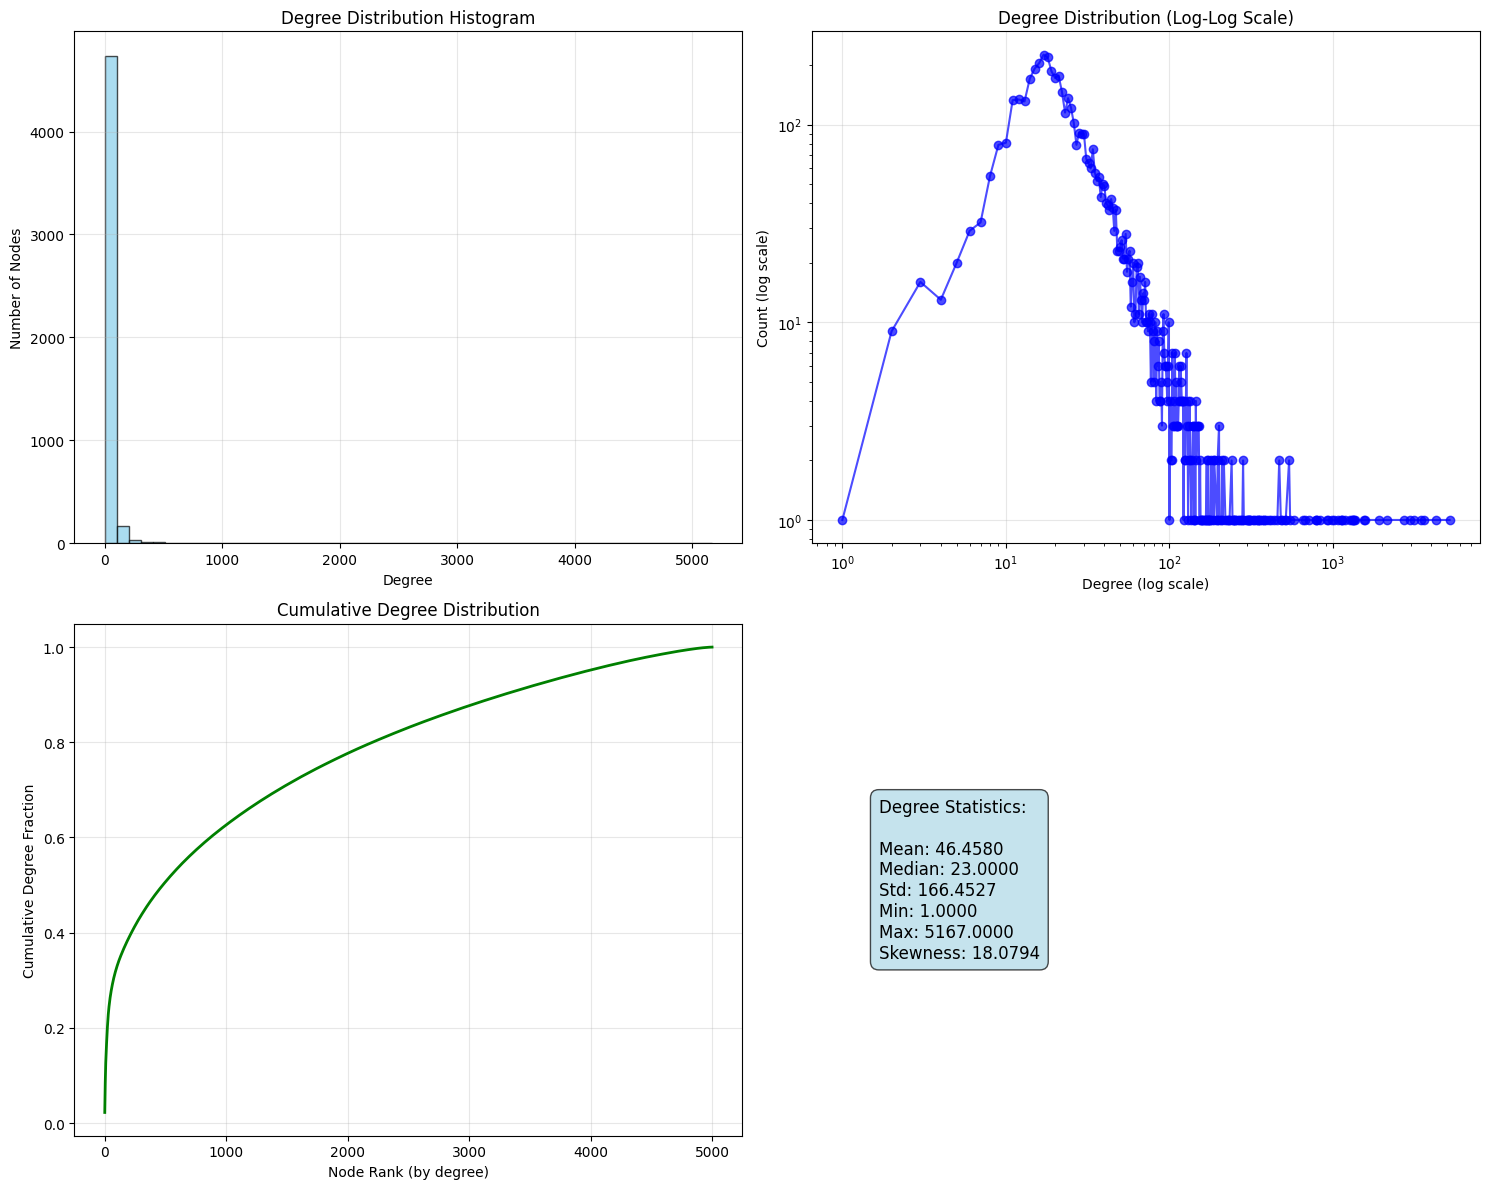

Mean degree: 46.46
Max degree: 5167
Degree variance: 27706.50

🎯 CENTRALITY MEASURES ANALYSIS
--------------------------------------------------
Calculating centrality measures...


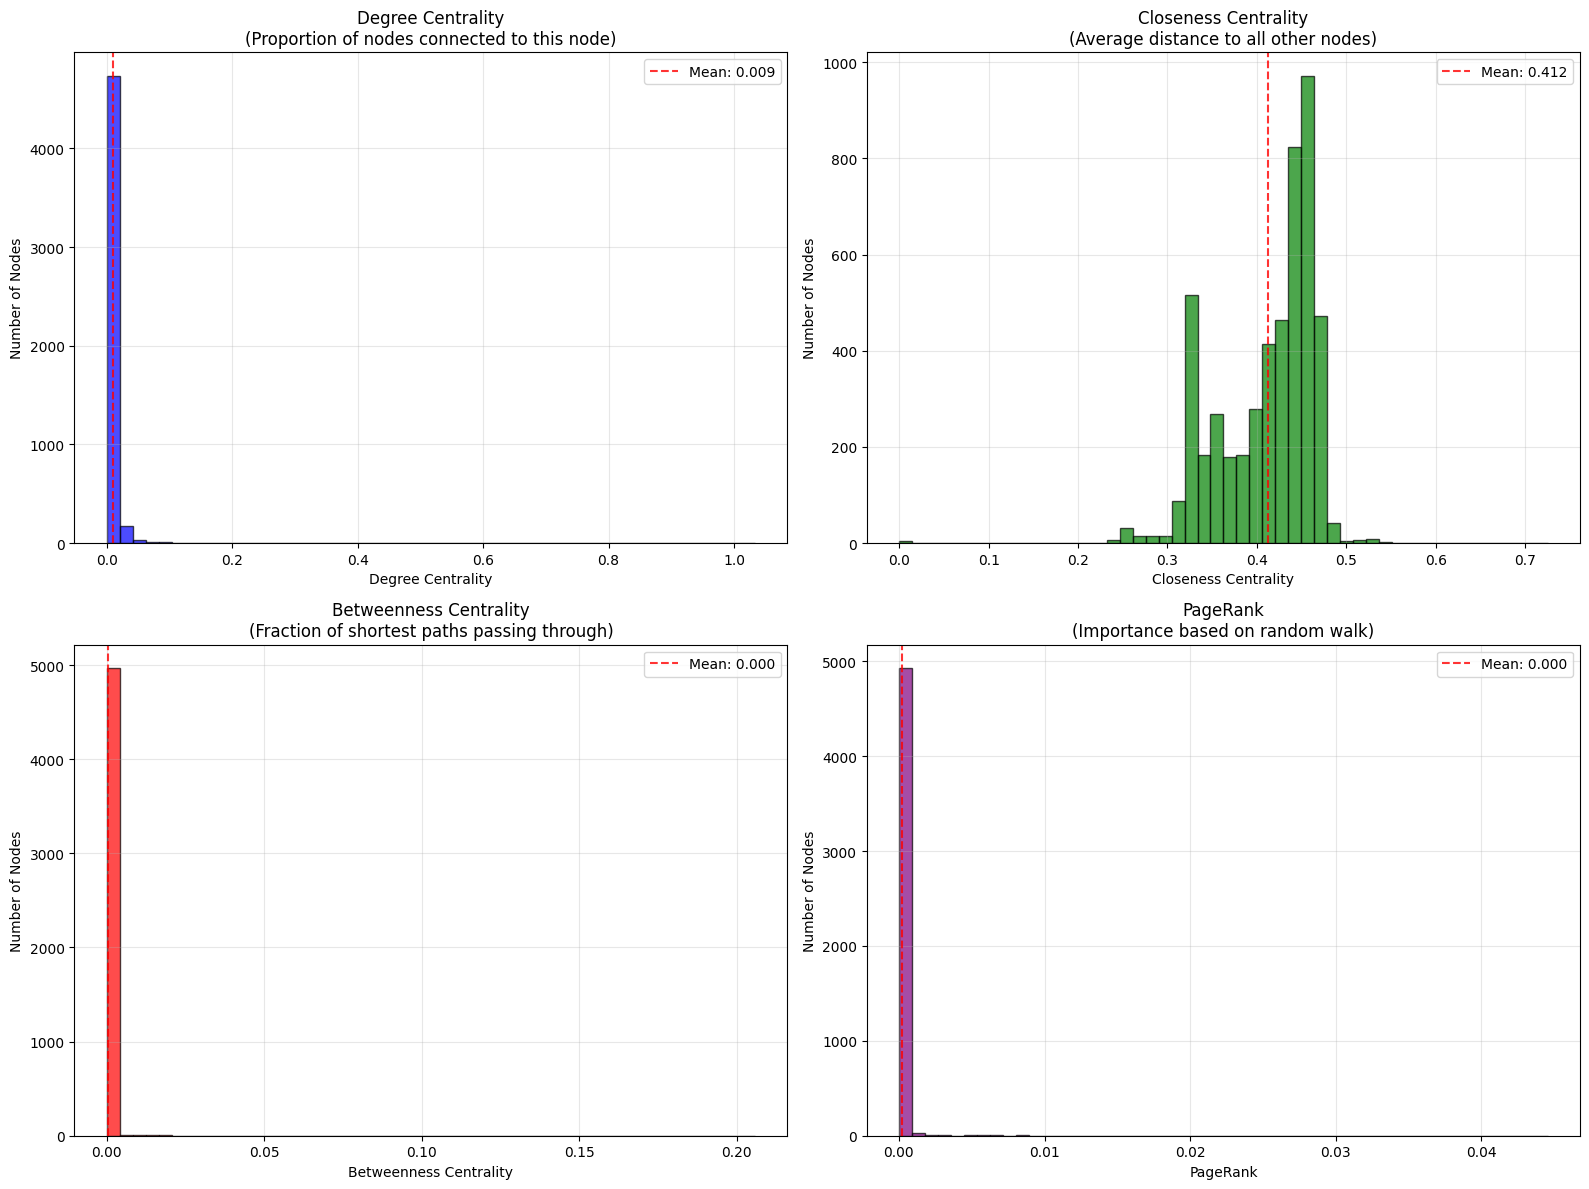


Top 5 nodes by each centrality measure:
----------------------------------------

Degree Centrality:
  token_00001: 1.0336
  token_00004: 0.8572
  token_00000: 0.7155
  token_00002: 0.6919
  token_00003: 0.6297

Closeness Centrality:
  token_00001: 0.7252
  token_00002: 0.6855
  token_00004: 0.6355
  token_00005: 0.6108
  token_00006: 0.5830

Betweenness Centrality:
  token_00001: 0.2059
  token_00004: 0.1437
  token_00000: 0.0984
  token_00003: 0.0768
  token_00002: 0.0665

PageRank:
  token_00000: 0.0445
  token_00001: 0.0412
  token_00002: 0.0296
  token_00003: 0.0237
  token_00004: 0.0199

🔗 CENTRALITY CORRELATIONS
------------------------------


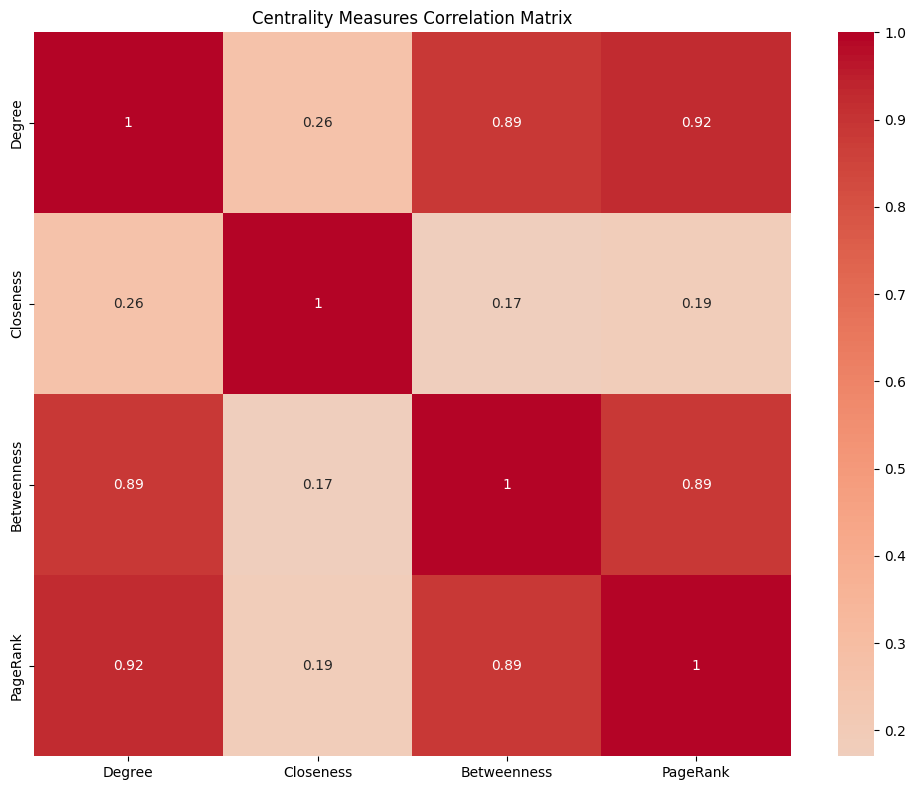

Key correlations:
  Degree ↔ PageRank: 0.920
  Closeness ↔ Betweenness: 0.170
  Degree ↔ Closeness: 0.262

🔗 CLUSTERING COEFFICIENT ANALYSIS
--------------------------------------------------
Clustering coefficient measures how well connected a node's neighbors are.
High clustering indicates local community structure.


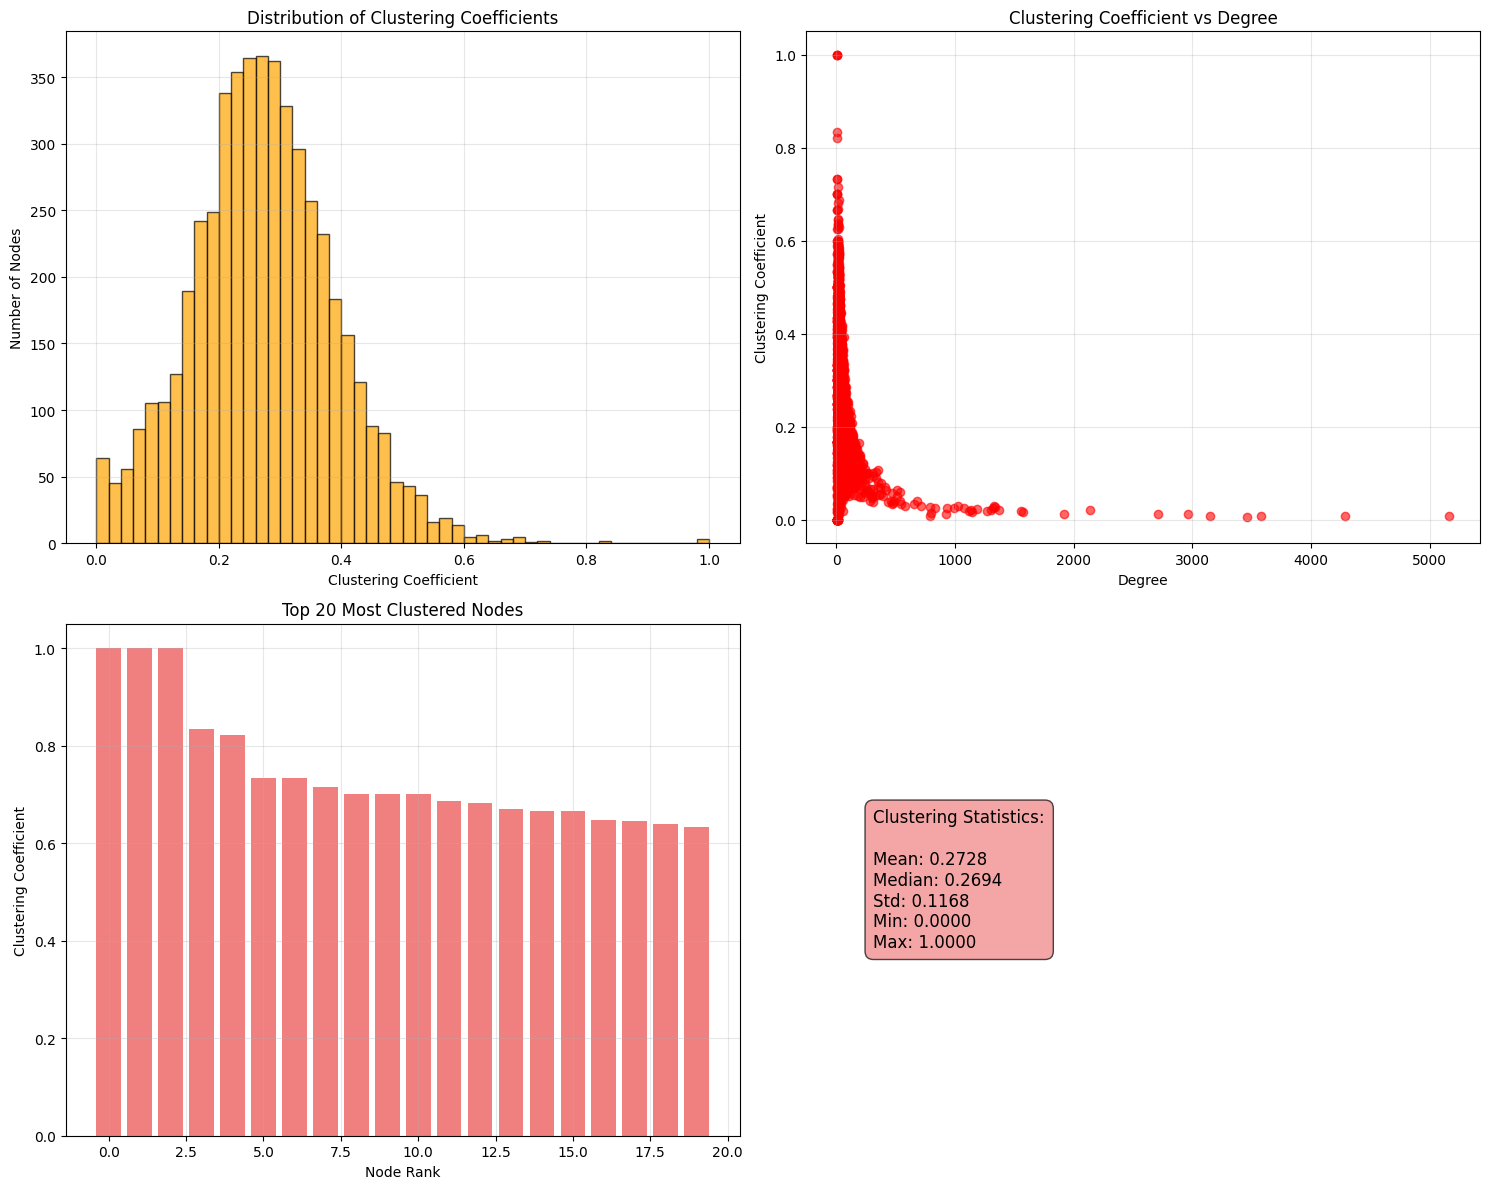

Average clustering coefficient: 0.2728
Maximum clustering coefficient: 1.0000

📊 COMPREHENSIVE GRAPH DASHBOARD
--------------------------------------------------


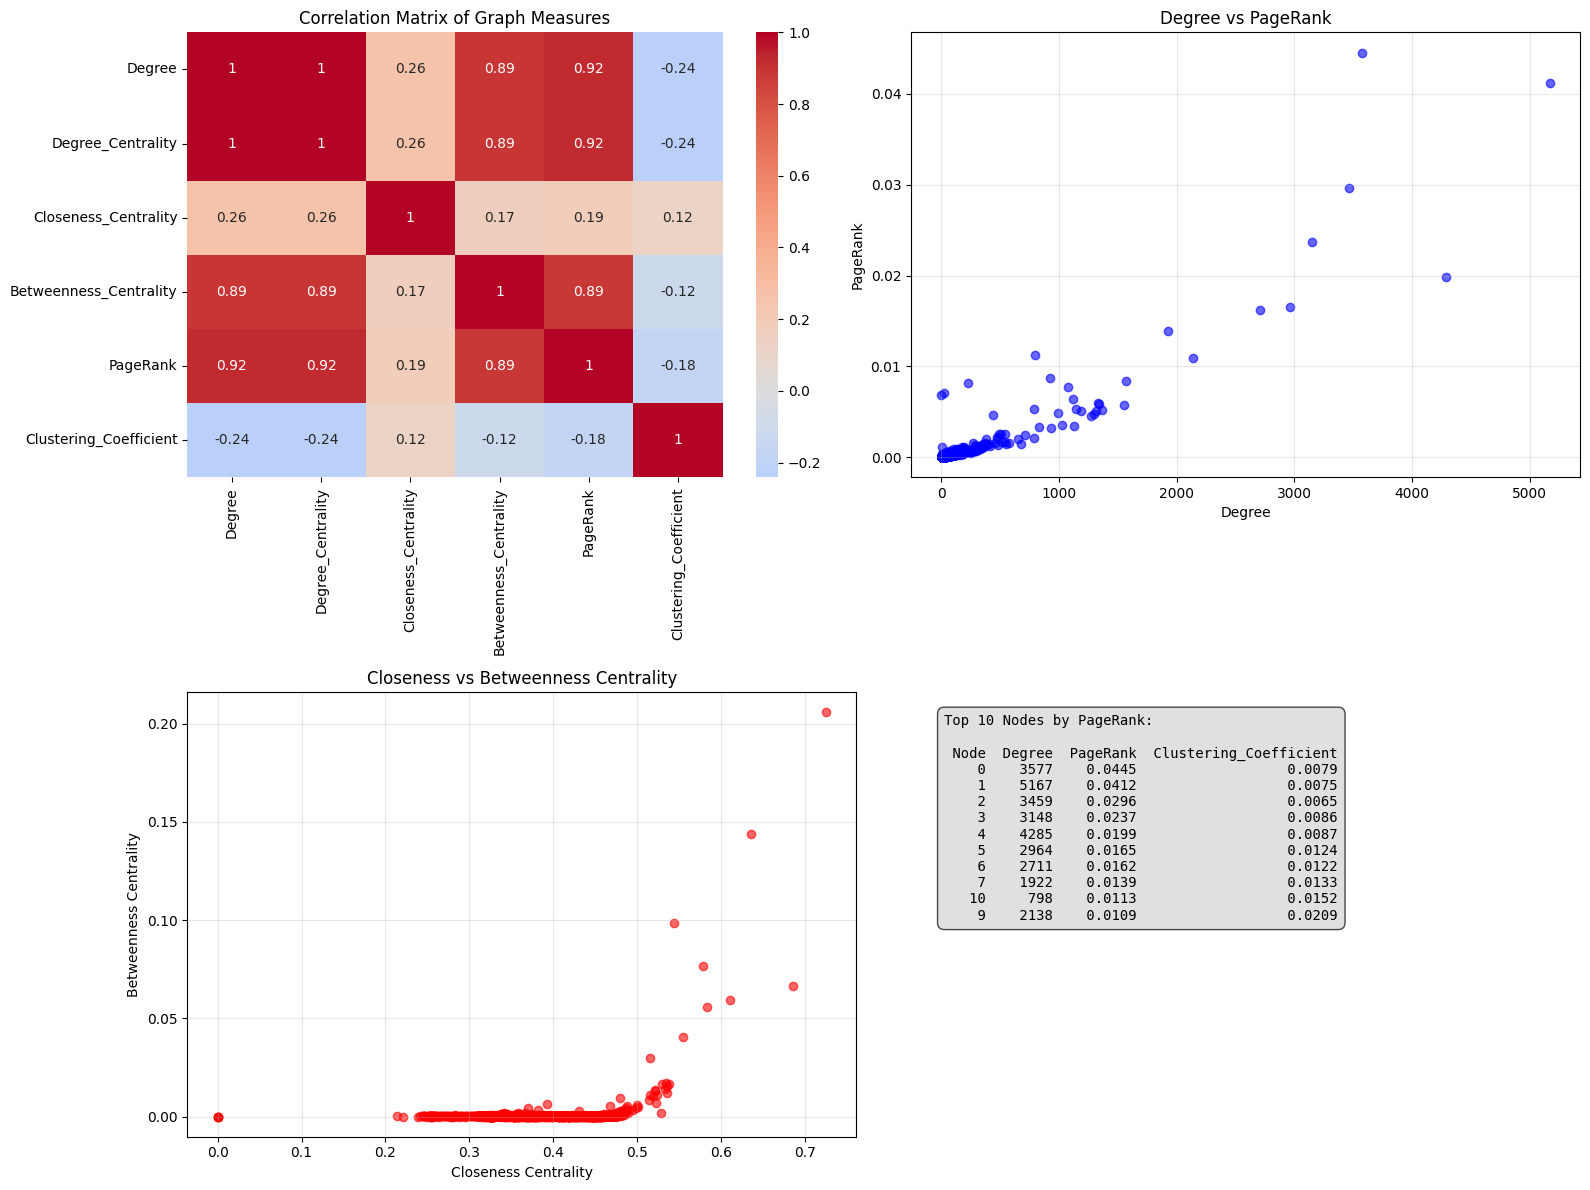

In [11]:
analyzer = GraphAnalyzer(lang_dataset)

# Print explanations
analyzer.explain_measures()

# Run all analyses and visualizations
analyzer.analyze_and_visualize_all("prosqa_graph_analysis")